In [ ]:
# ================================================================
# 0. Bibliotecas
# ----------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path
import os
from typing import Optional, Dict

In [16]:
import pandas as pd
from pathlib import Path

# ---------------------------------------------------------------
# 1) Caminho do seu Excel
# ---------------------------------------------------------------
excel_path = r"..\Banco de dados\APC Branqueamento _Dados Valores.xlsx"

# ---------------------------------------------------------------
# 2) Ler as abas que você precisa
# ---------------------------------------------------------------
df_qualidade = pd.read_excel(excel_path, sheet_name="Qualidade")
df_limites   = pd.read_excel(excel_path, sheet_name="Limites")

# (opcional) conferindo as primeiras linhas
display(df_qualidade.head())
display(df_limites.head())

,timpestap,3205FI003.PNT,3205NC008.MEAS,3205QI007C.PNT,3205QI007D.PNT,3205QM007DQO,3205QC037.MEAS,3205TC028.MEAS,3205QI044D.PNT,3205QI049.PNT,...,3205QI359D.PNT,3201QI359HEX.PNT,3205QM359DQO,3205QC360.MEAS,3257QM0001B_VISC_PA,3257QM0001ALVURA,3257QM0001B_SUJ-SH,3257QM0001B_SUJ- Pitch,3257QM0001REV_ALV,perda_alvura
0,2025-01-01 00:00:00,3201.091922,11.402430,8.850368,63.314919,15.940959,3.916582,87.179298,77.347328,75.293254,...,90.641197,4.392224,2.916943,5.558051,809.04375,89.989915,3.991667,3.991667,1.7,0.651283
1,2025-01-01 00:01:00,3197.253526,11.324182,8.850368,63.314919,15.941176,3.912356,86.258868,77.347328,75.273332,...,90.641197,4.392224,2.917039,5.563657,809.13125,89.989748,3.975000,3.975000,1.7,0.651449
2,2025-01-01 00:02:00,3195.928730,11.248729,8.850368,63.314919,15.941393,3.947402,87.133673,77.347328,75.253408,...,90.641197,4.392224,2.917134,5.581635,809.21875,89.989581,3.958333,3.958333,1.7,0.651616
3,2025-01-01 00:03:00,3196.951868,11.310435,8.850368,63.314919,15.941611,3.906816,87.895089,77.347328,75.233475,...,90.641197,4.392224,2.917230,5.599979,809.30625,89.989415,3.941667,3.941667,1.7,0.651782
4,2025-01-01 00:04:00,3197.975006,11.315998,8.850368,63.314919,15.941828,3.839518,87.104104,77.347328,75.213538,...,90.641197,4.392224,2.917325,5.591303,809.39375,89.989248,3.925000,3.925000,1.7,0.651949


,Nome,Tag,LO,HI
0,ritmo_produção,3205FI003.PNT,2800.0,3500.0
1,Dhot_cs%_alimentação,3205NC008.MEAS,10.0,20.0
2,Dhot_kappa_entrada,3205QI007C.PNT,11.0,14.0
3,Dhot_alvura_entrada,3205QI007D.PNT,60.0,65.0
4,Dhot_dqo_entrada,3205QM007DQO,5.0,9.0


In [17]:
out_dir = r"..\Banco de dados"

# Garante que a pasta exista
os.makedirs(out_dir, exist_ok=True)

# Monta os caminhos dos CSVs
csv_qualidade = os.path.join(out_dir, "qualidade.csv")
csv_limites   = os.path.join(out_dir, "limites.csv")

# Salva
df_qualidade.to_csv(csv_qualidade, index=False, encoding="utf-8")
df_limites.to_csv(csv_limites,   index=False, encoding="utf-8")

In [18]:
# ---------- estilo global ----------
plt.rcParams.update({
    "figure.dpi": 120,
    "font.family": "DejaVu Sans",
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.color": "#E5E5E5",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

# ================================================================
# 1. Funções utilitárias
# ----------------------------------------------------------------

In [19]:
def load_catalog(catalog_path: str, sheet_name=0) -> pd.DataFrame:
    """
    Lê a planilha de catálogo (metadados dos KPIs).
    Aceita .xlsx, .xls ou .csv.
    """
    if catalog_path.lower().endswith((".xls", ".xlsx")):
        return pd.read_excel(catalog_path, sheet_name=sheet_name)
    return pd.read_csv(catalog_path, sep=";|,", engine="python")  # tenta ; ou ,

In [20]:
def load_process_data(data_path: str, sheet_name=0) -> pd.DataFrame:
    """
    Lê a planilha com as séries históricas (colunas = tags, linhas = medições).
    """
    if data_path.lower().endswith((".xls", ".xlsx")):
        return pd.read_excel(data_path, sheet_name=sheet_name)
    return pd.read_csv(data_path, sep=";|,", engine="python")

In [29]:
def gen_hist(
    serie: pd.Series,
    title: str,
    lo: Optional[float] = None,
    hi: Optional[float] = None,
    palette: Optional[Dict[str, str]] = None,
) -> Dict[str, float]:
    """
    Desenha histograma e devolve métricas num dicionário.
    palette = {"bars": "#hex", "lo": "#hex", "hi": "#hex"}
    """
    default_palette = {"bars": "#4B91CC", "lo": "#C0392B", "hi": "#6C3483"}
    colors = palette or default_palette

    # ---------- estatísticas ----------
    media = serie.mean()
    std = serie.std(ddof=1)
    cv = 100 * std / media
    pct_dentro = (
        100 * ((serie >= lo) & (serie <= hi)).mean() if lo is not None and hi is not None else np.nan
    )
    pct_abaixo = 100 * (serie < lo).mean() if lo is not None else np.nan
    pct_acima = 100 * (serie > hi).mean() if hi is not None else np.nan

    # ---------- plot ----------
    fig, ax = plt.subplots(figsize=(10, 5.2))
    ax.hist(
        serie.dropna(),
        bins=40,
        color=colors["bars"],
        edgecolor="white",
        linewidth=0.8,
        alpha=0.9,
    )
    if lo is not None:
        ax.axvline(lo, color=colors["lo"], ls="--", lw=2)
    if hi is not None:
        ax.axvline(hi, color=colors["hi"], ls="--", lw=2)

    ax.set_title(title, weight="bold", pad=8)
    ax.set_xlabel("Valor da variável")
    ax.set_ylabel("Frequência")
    ax.margins(x=0.02)

    # ---------- legenda ----------
    handles: List = [Patch(facecolor=colors["bars"], label=title.split(" – ")[0])]
    if lo is not None:
        handles.append(Line2D([], [], color=colors["lo"], ls="--", lw=2, label=f"Lo: {lo}"))
    if hi is not None:
        handles.append(Line2D([], [], color=colors["hi"], ls="--", lw=2, label=f"Hi: {hi}"))
    handles += [
        Patch(color="none", label=f"Média: {media:.2f}"),
        Patch(color="none", label=f"Std: {std:.2f}"),
        Patch(color="none", label=f"CV: {cv:.2f}%"),
    ]
    if not np.isnan(pct_dentro):
        handles += [
            Patch(color="none", label=f"Dentro dos Limites: {pct_dentro:.2f}%"),
            Patch(color="none", label=f"Abaixo dos Limites: {pct_abaixo:.2f}%"),
            Patch(color="none", label=f"Acima dos Limites: {pct_acima:.2f}%"),
        ]

    plt.subplots_adjust(right=0.78)
    ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=True)
    plt.tight_layout()
    plt.show()

    # ---------- retorno ----------
    return {
        "Título": title,
        "Média": media,
        "Std": std,
        "CV_%": cv,
        "Lo": lo,
        "Hi": hi,
        "%_dentro": pct_dentro,
        "%_abaixo": pct_abaixo,
        "%_acima": pct_acima,
        "N_amostras": len(serie),
    }

In [32]:
def plot_from_catalog(
    catalog_df: pd.DataFrame,
    data_df: pd.DataFrame,
    stage: Optional[str] = None,
    save: bool = False,
    out_dir: str = "figs",
) -> pd.DataFrame:
    """
    Gera histogramas para cada linha do catálogo e devolve DataFrame de métricas.
    """
    if stage:
        catalog_df = catalog_df[catalog_df["Estágio"].str.fullmatch(stage, case=False)]

    if save:
        Path(out_dir).mkdir(parents=True, exist_ok=True)

    results: List[Dict] = []

    for _, row in catalog_df.iterrows():
        tag = str(row["Tag"]).strip()
        if tag not in data_df.columns:
            print(f"⚠ Tag não encontrada → {tag}")
            continue

        serie = data_df[tag].dropna()
        title = f"{row['Nome']} ({tag})"
        lo, hi = row.get("LO"), row.get("HI")

        metrics = gen_hist(
            serie,
            title,
            lo if pd.notna(lo) else None,
            hi if pd.notna(hi) else None,
        )
        results.append(metrics)

        if save:
            fname = f"{out_dir}/{tag}.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")
            plt.close()

    return pd.DataFrame(results)

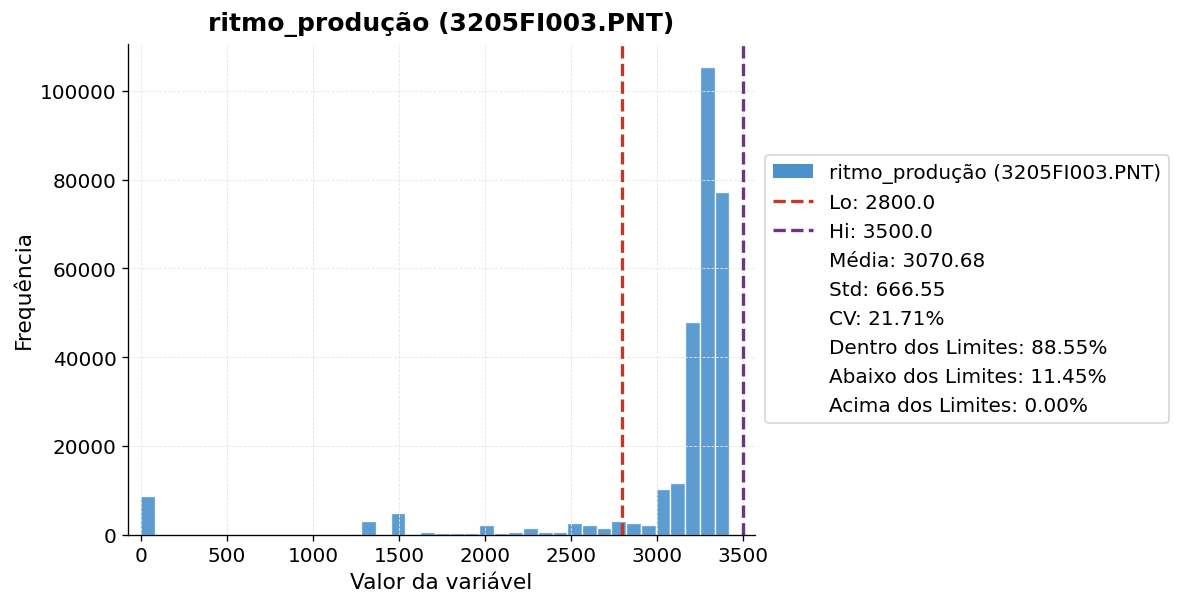

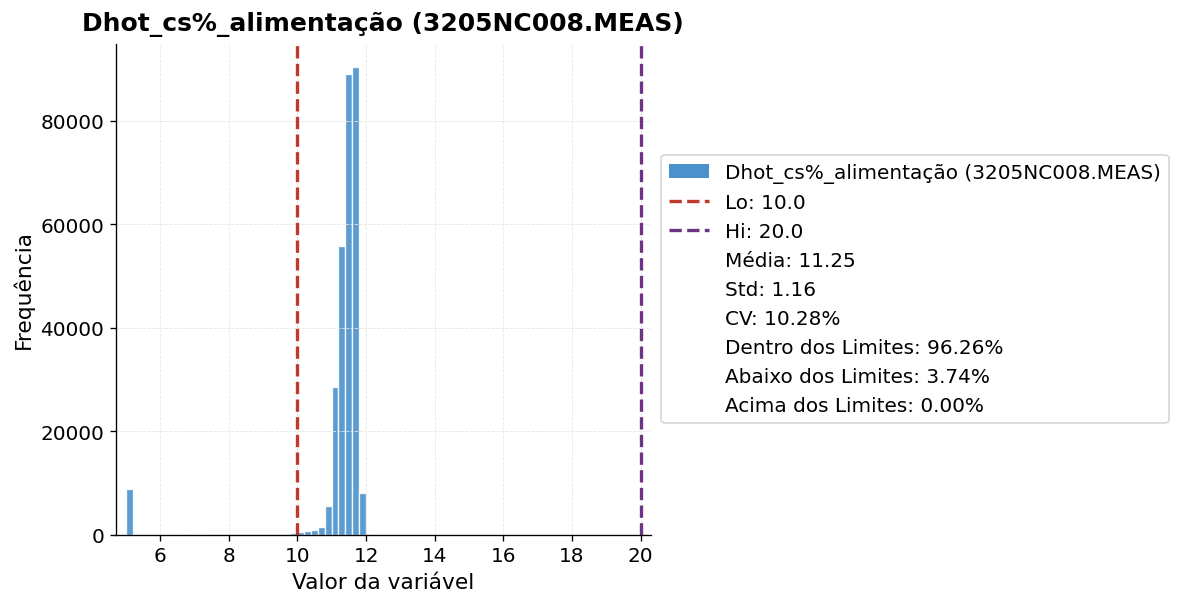

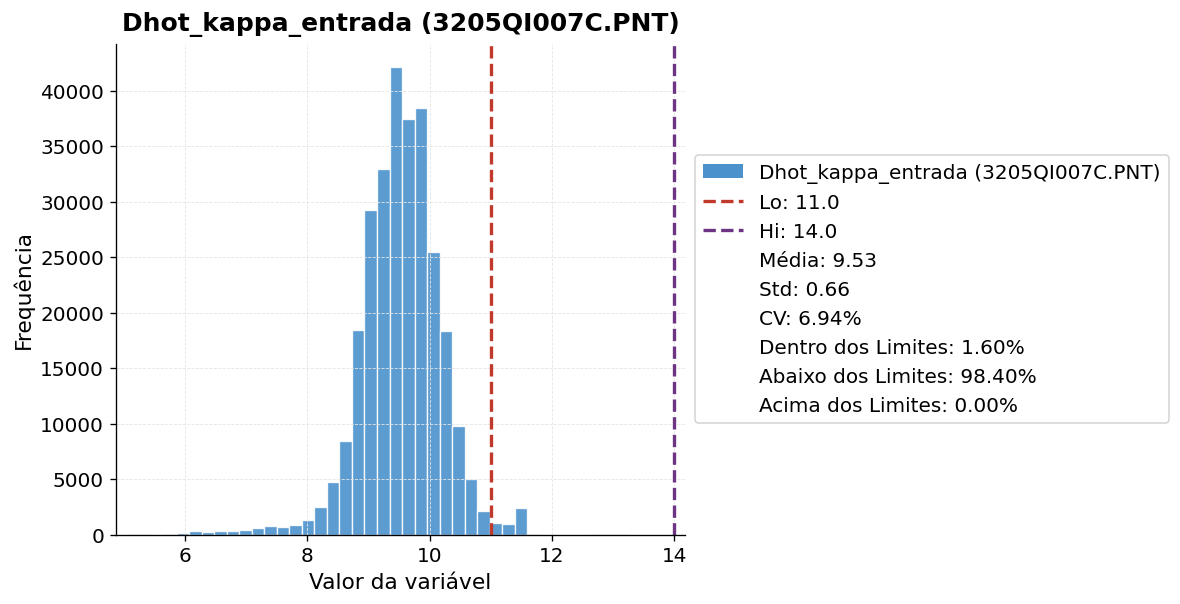

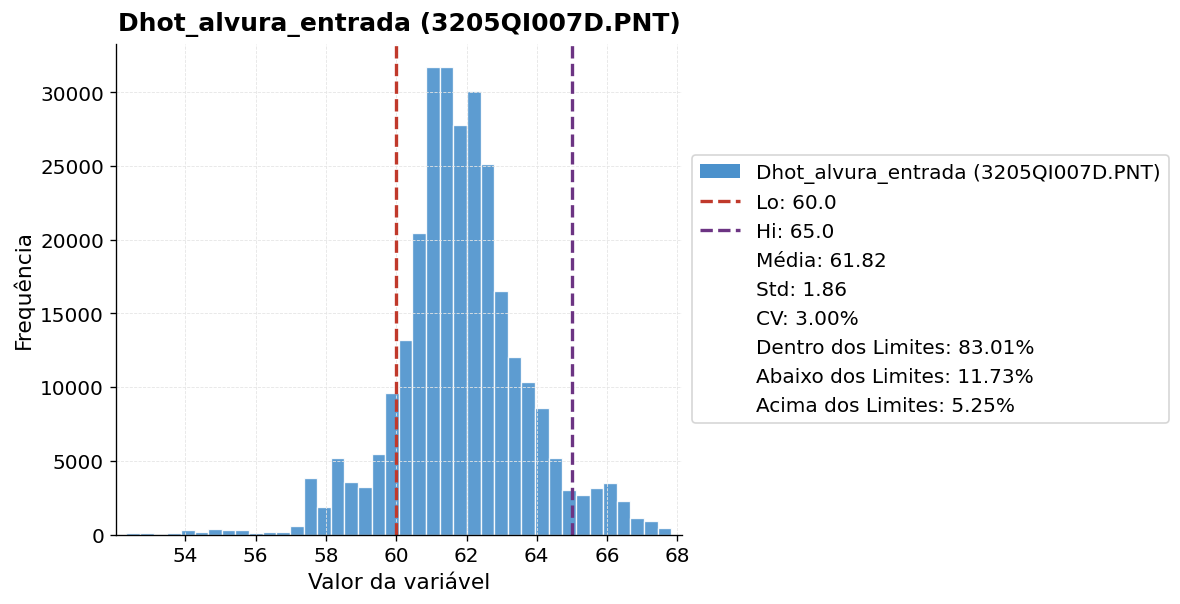

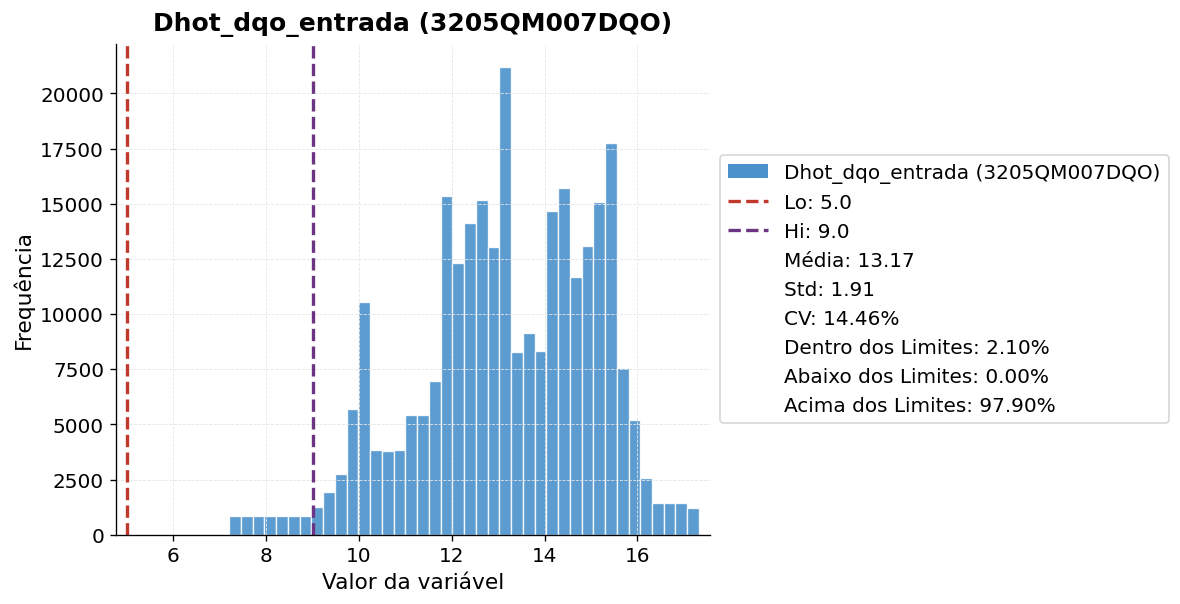

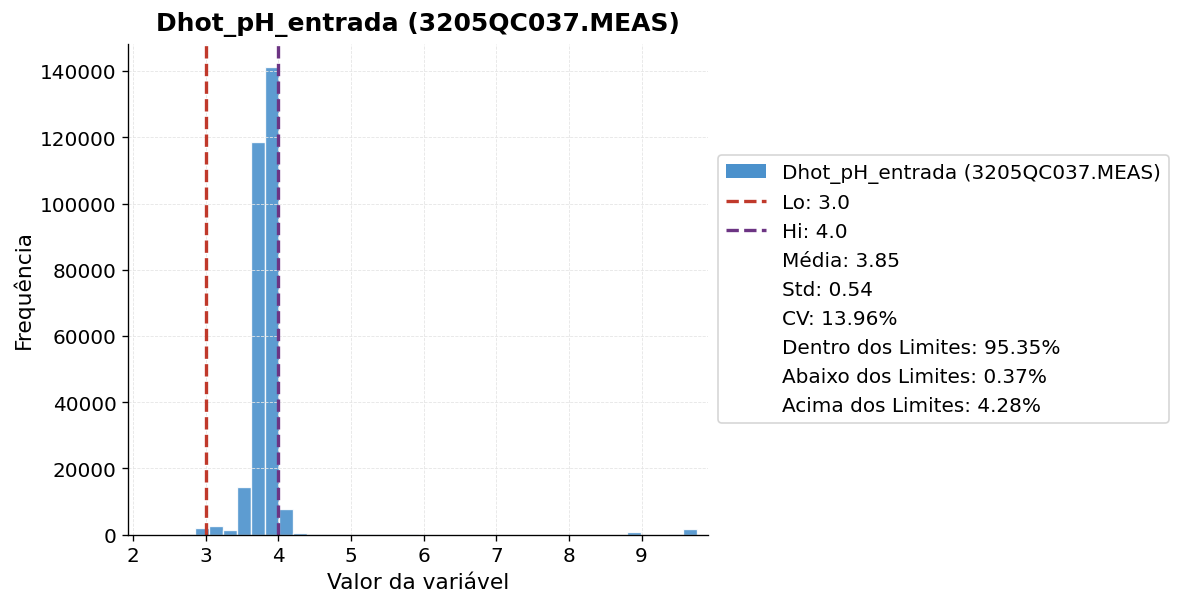

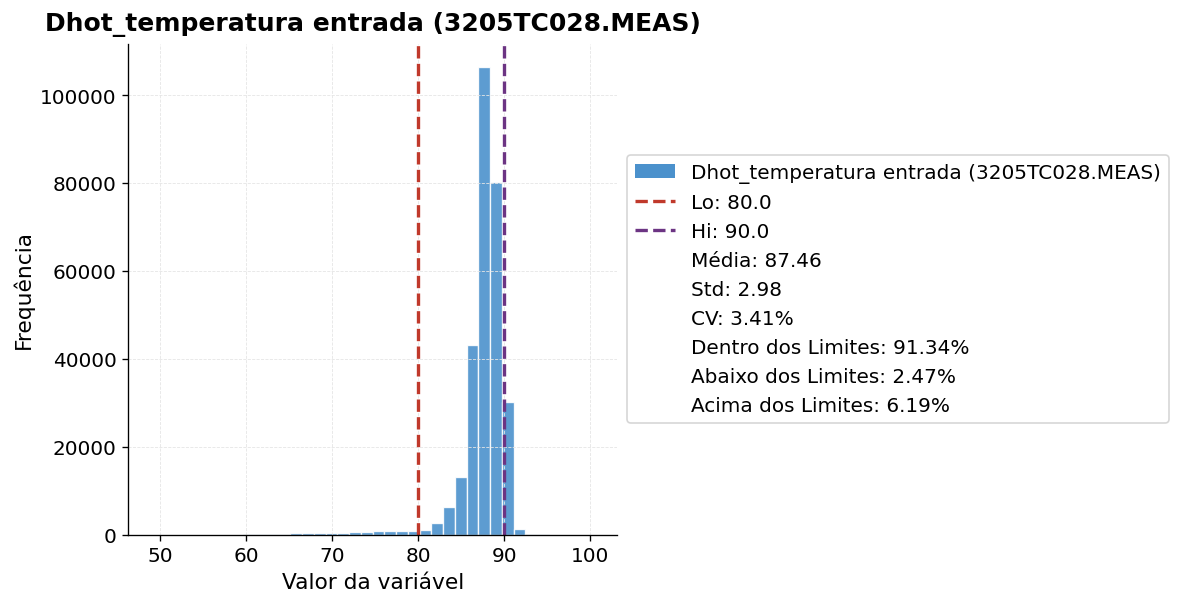

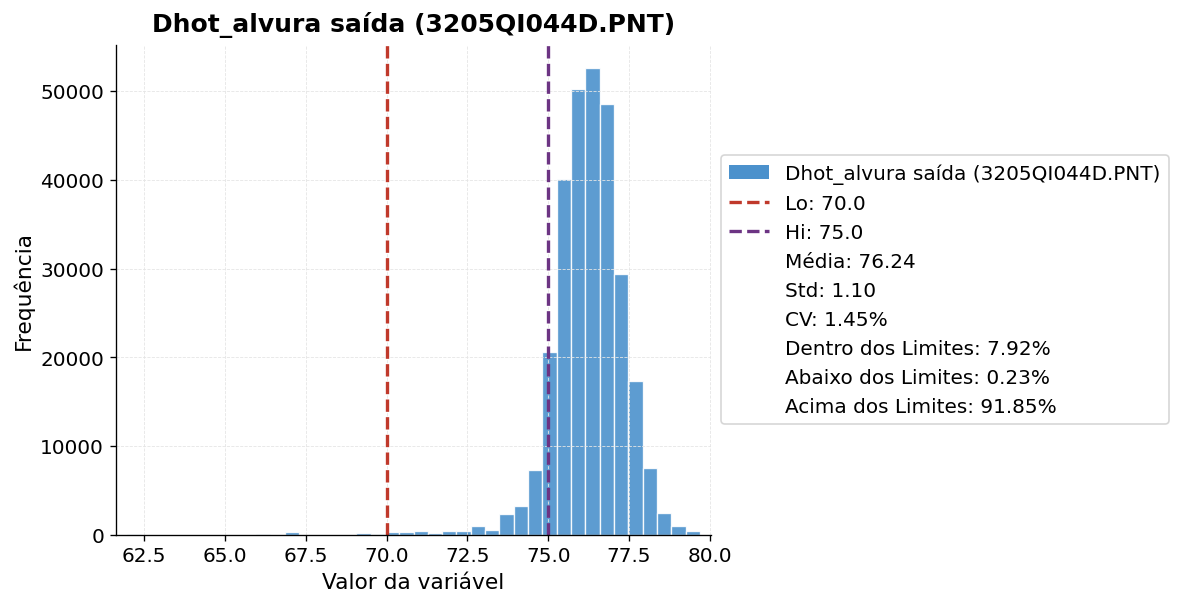

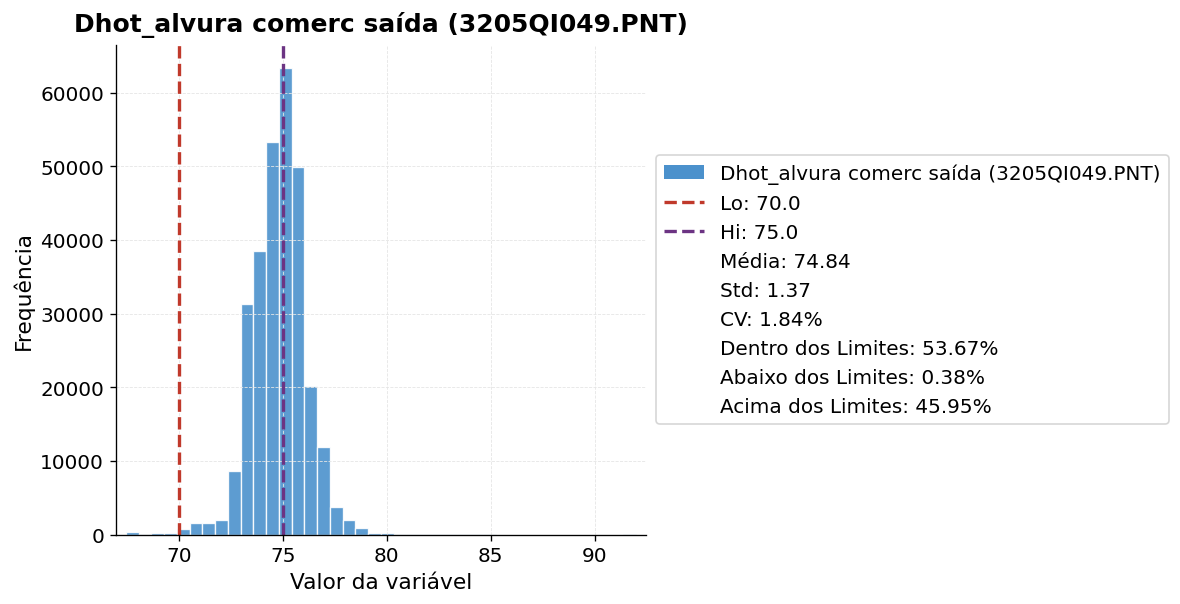

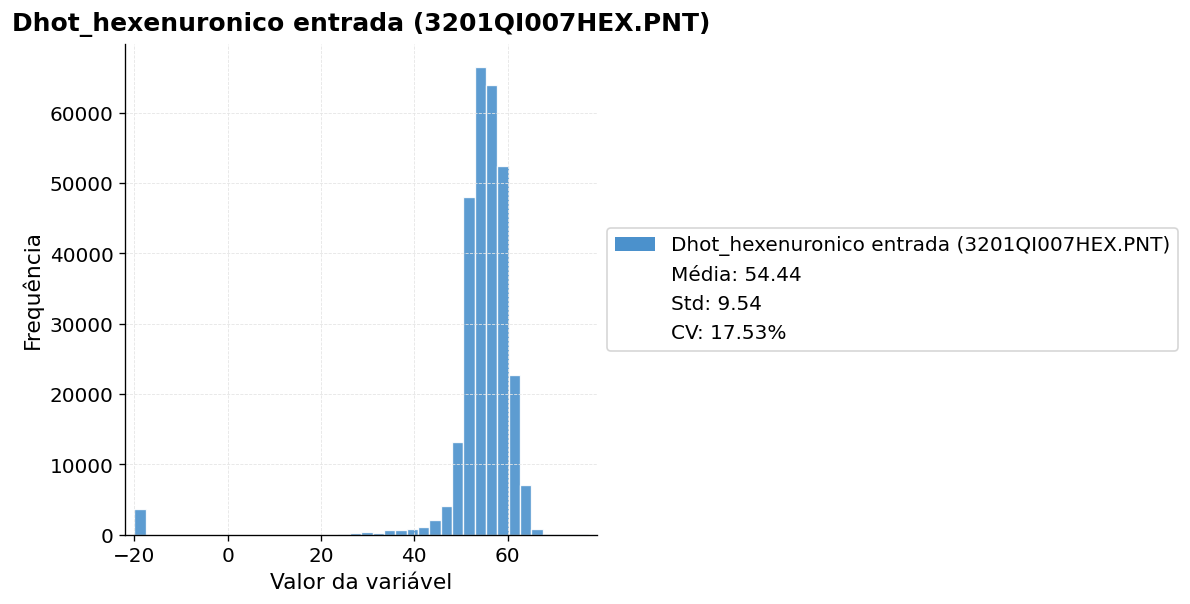

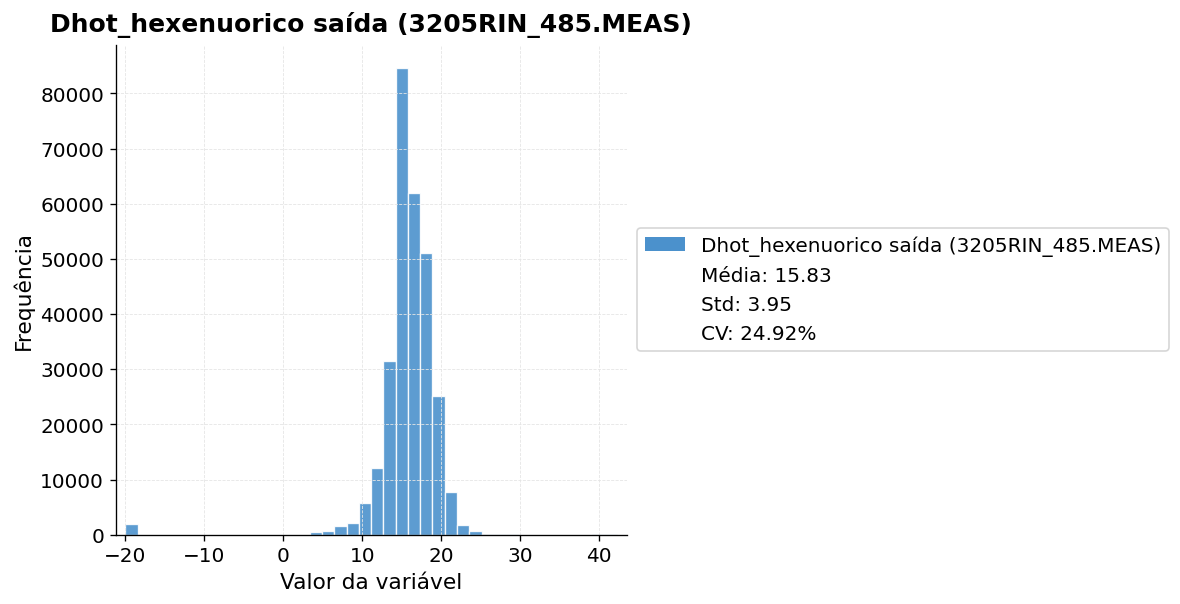

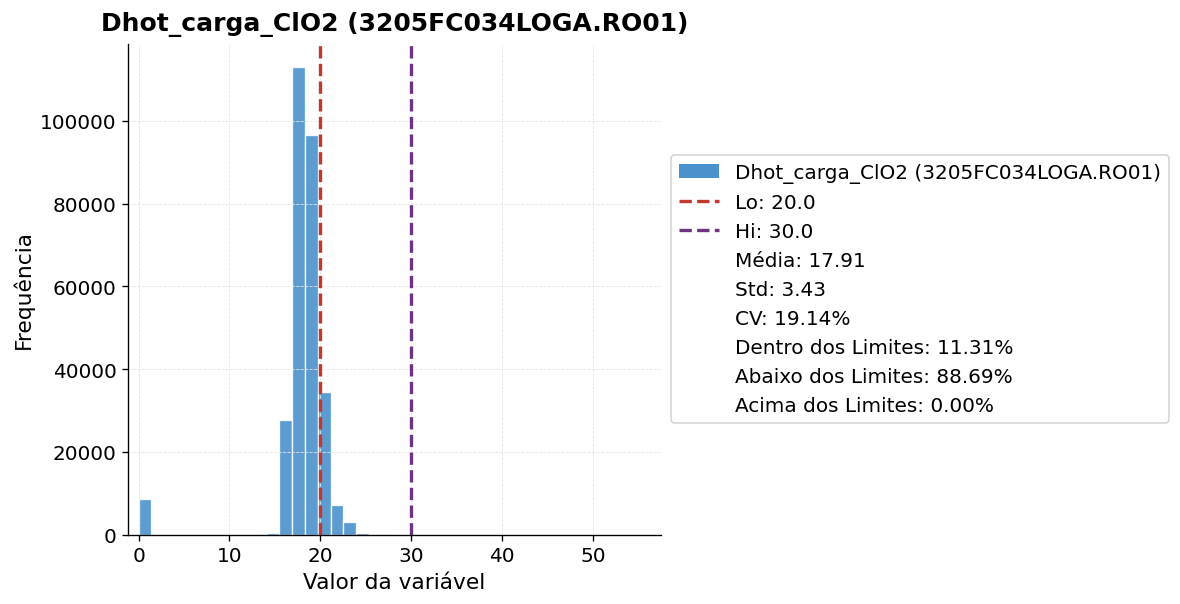

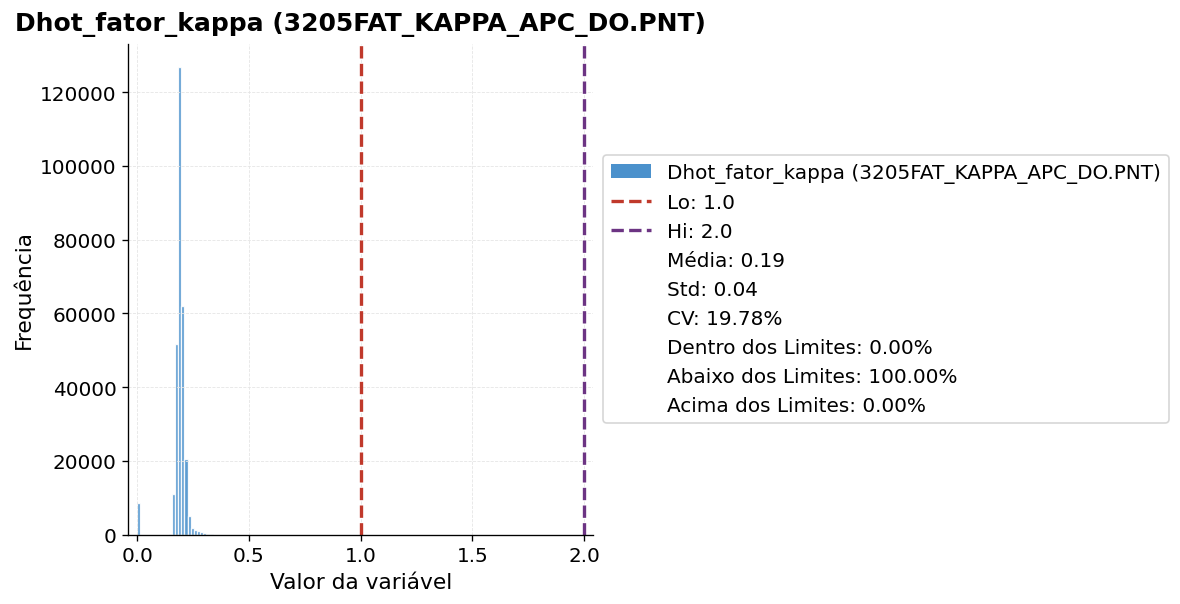

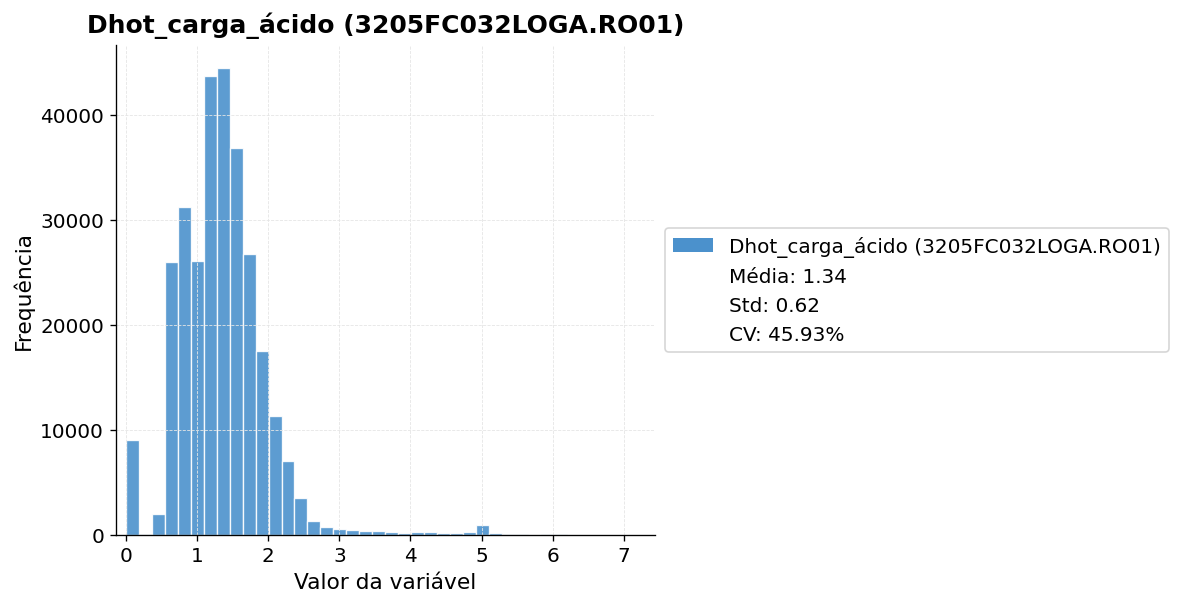

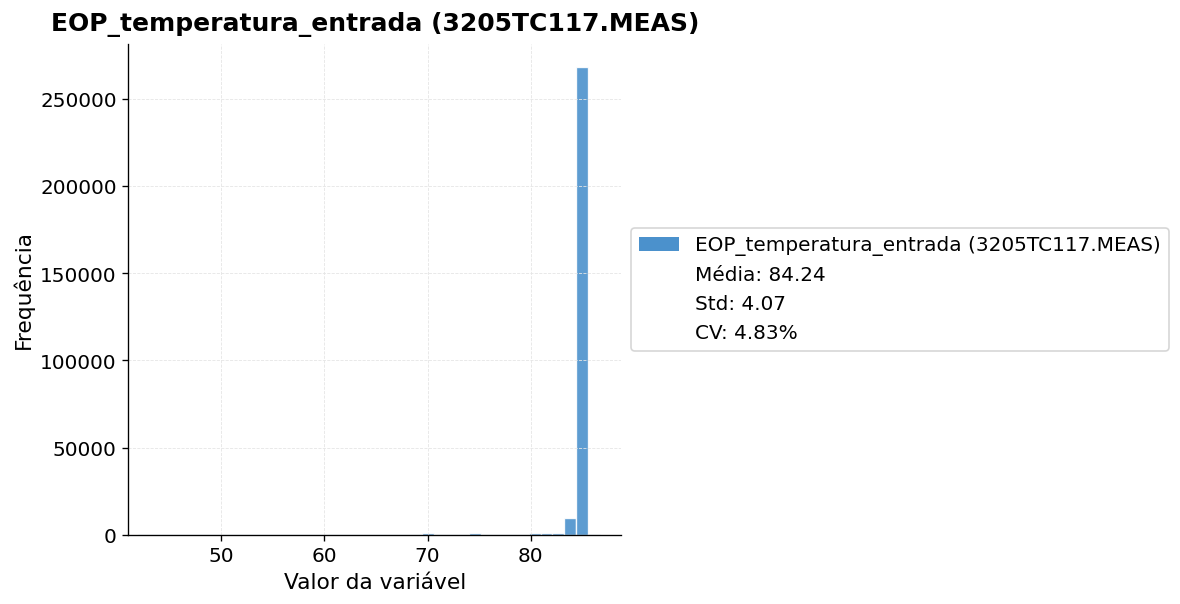

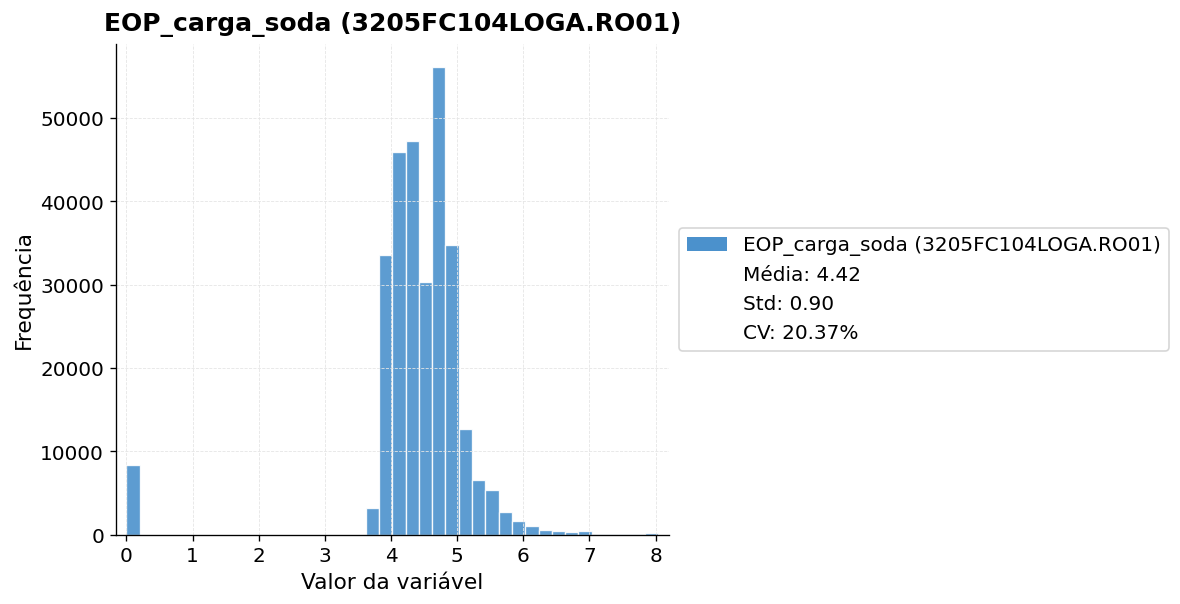

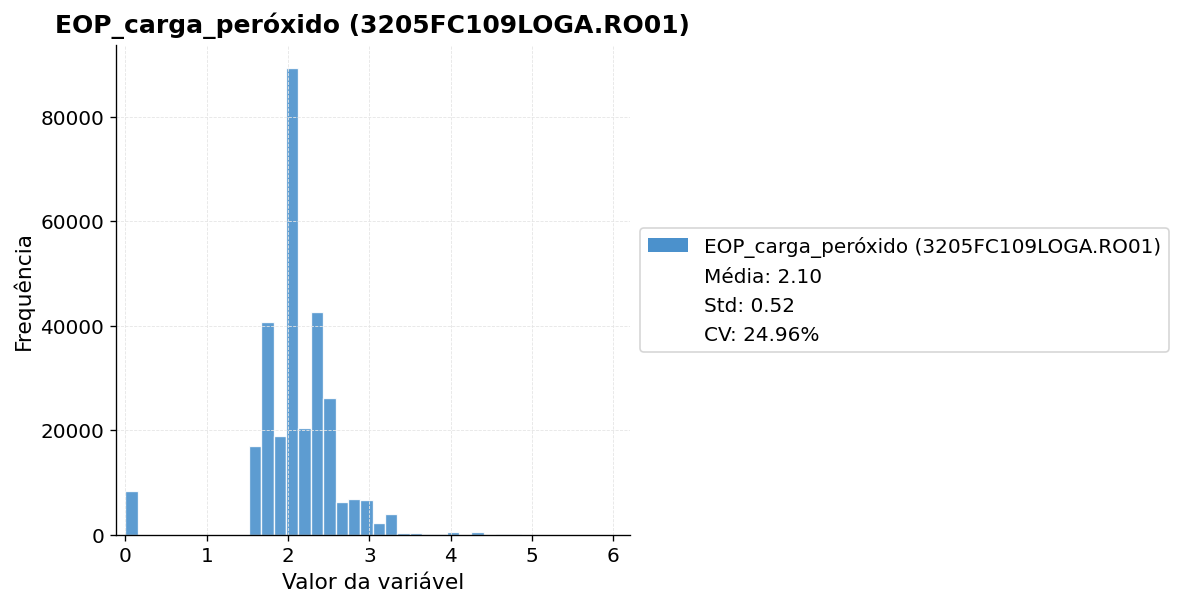

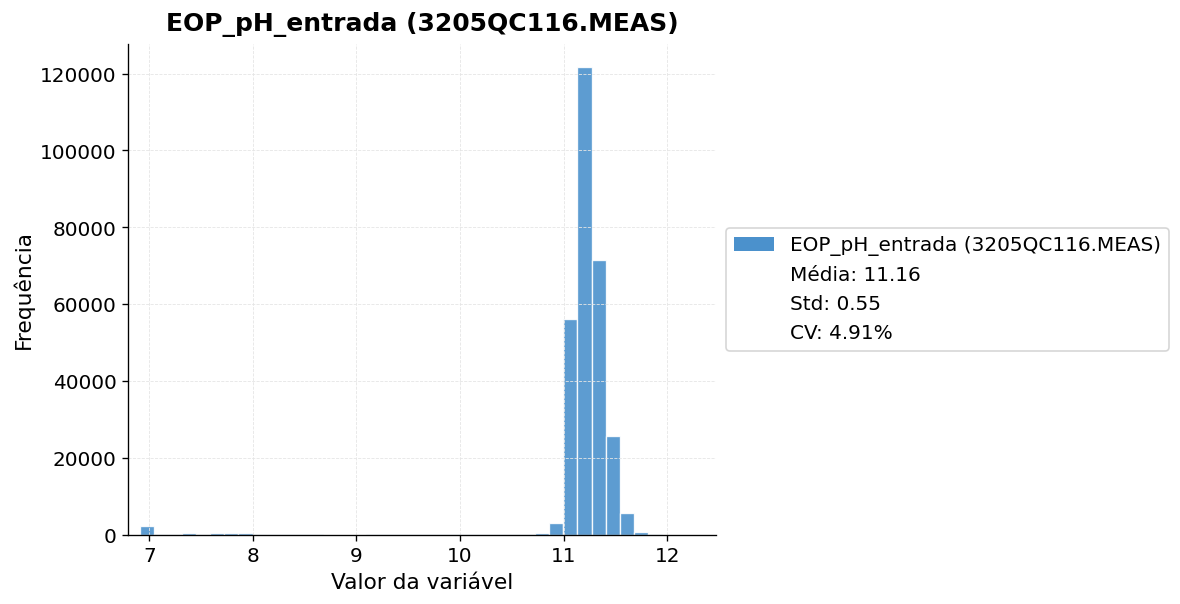

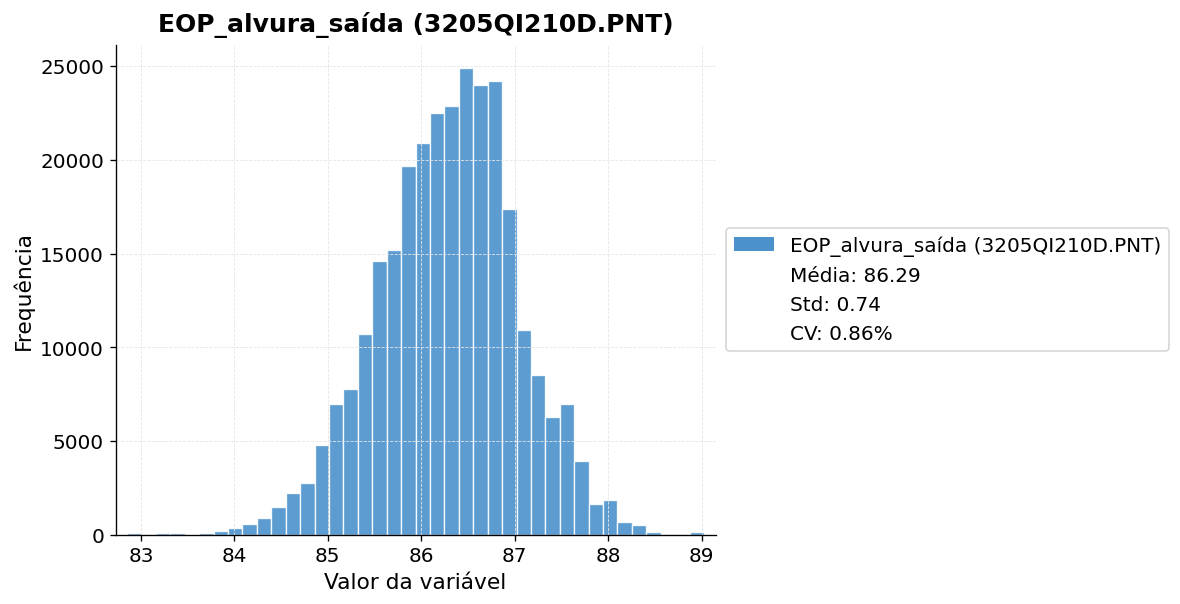

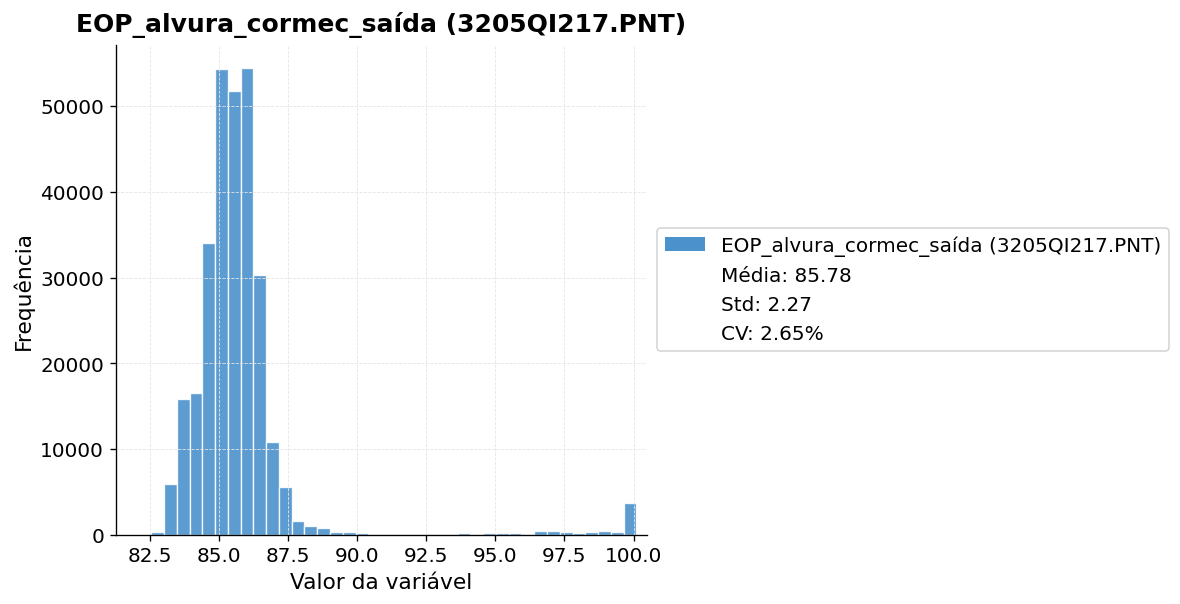

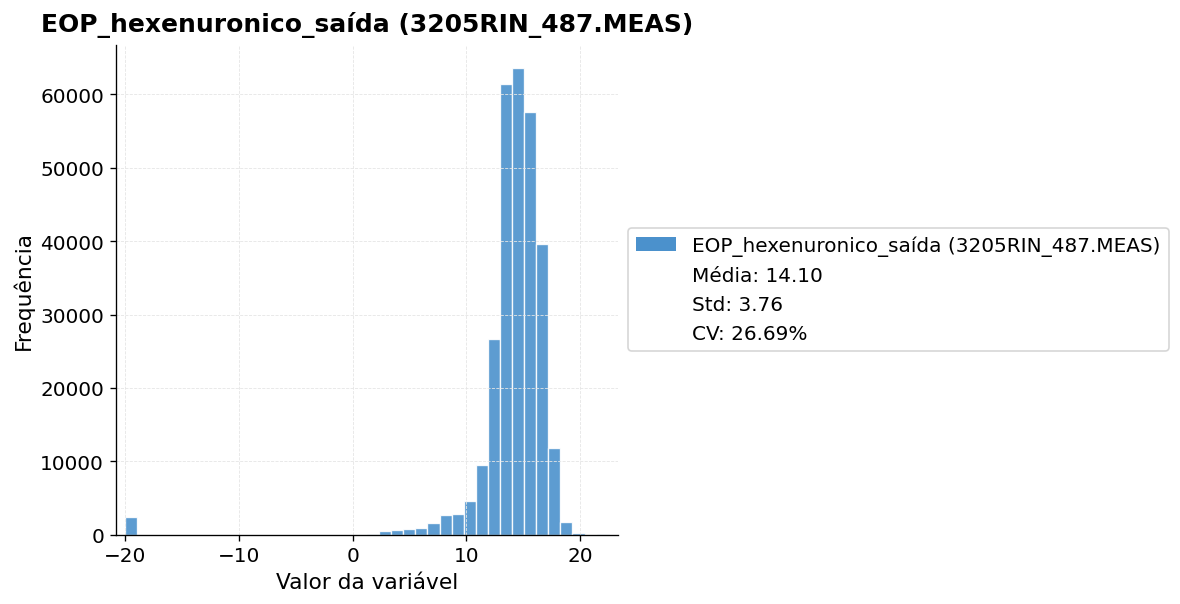

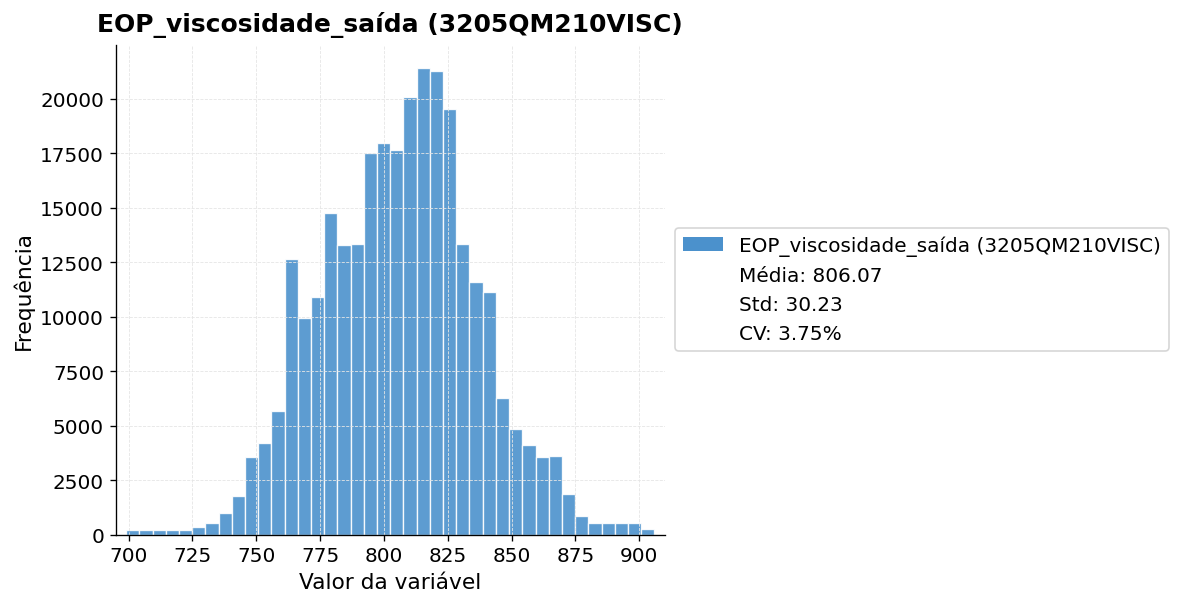

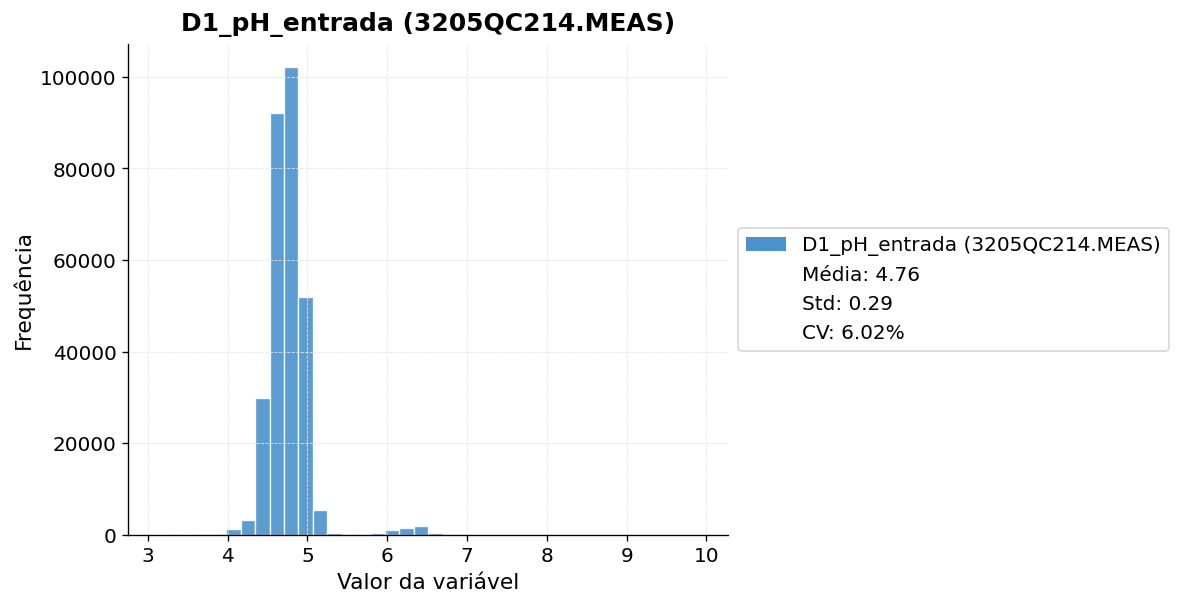

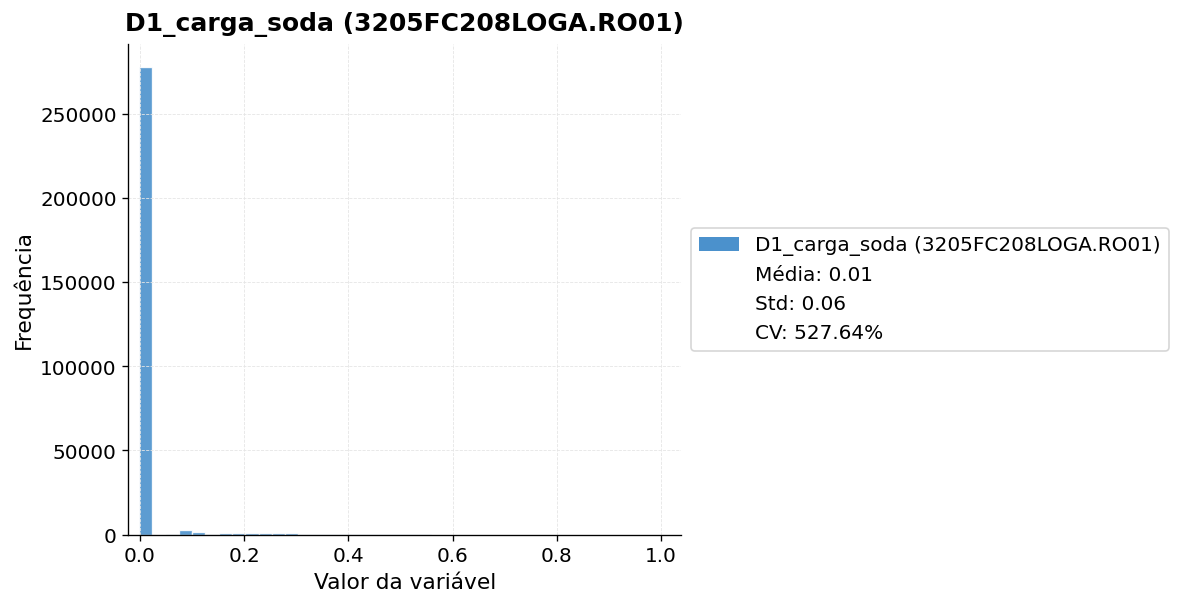

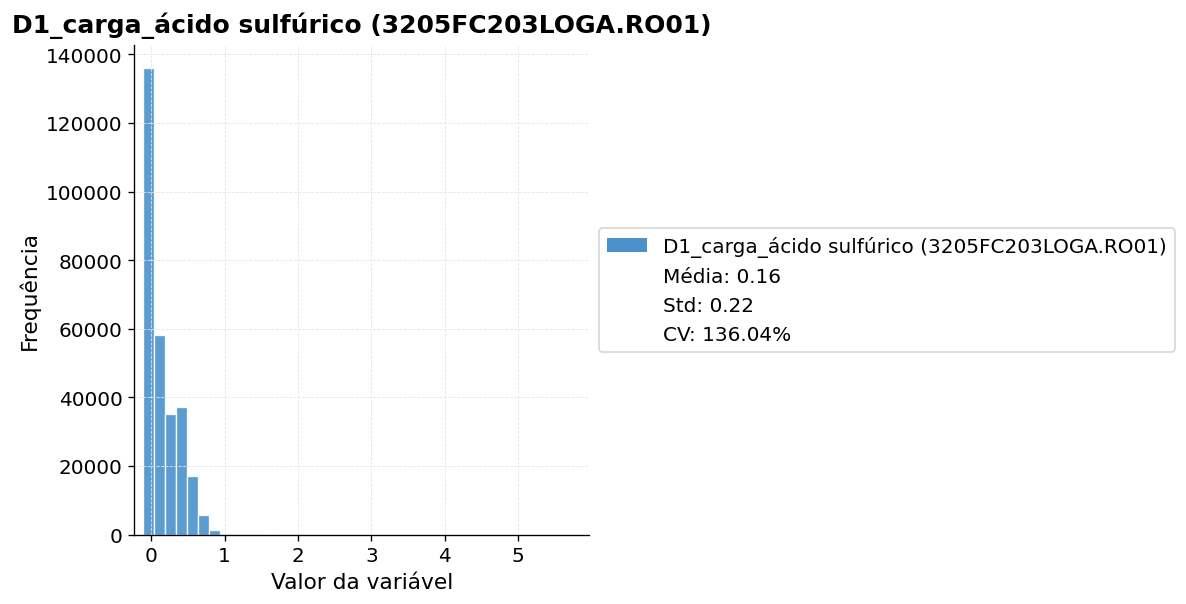

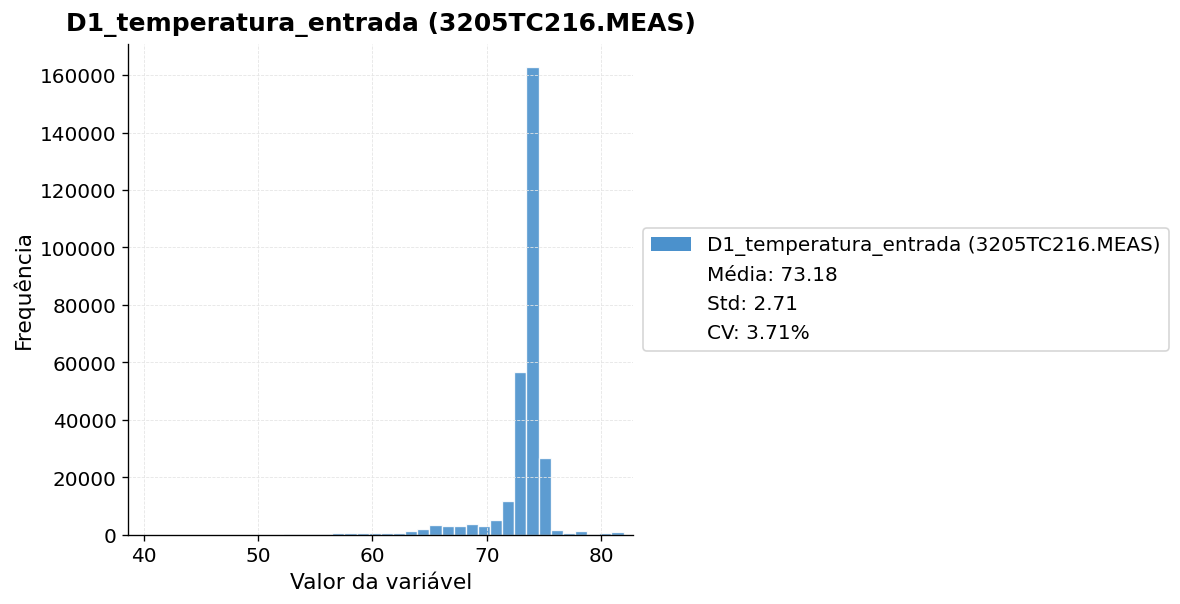

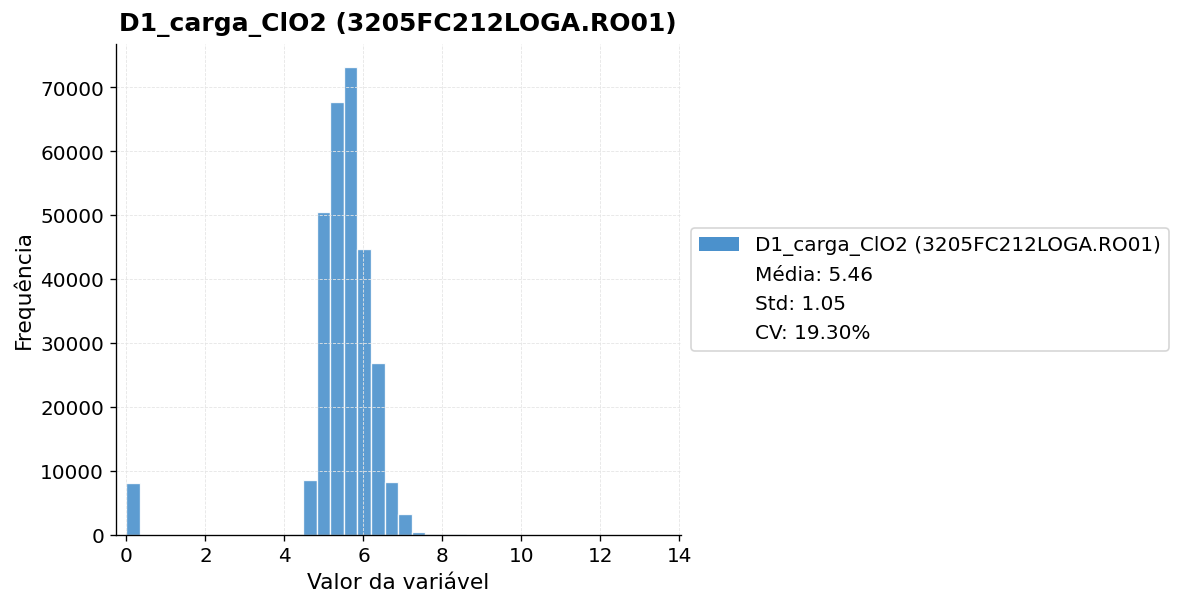

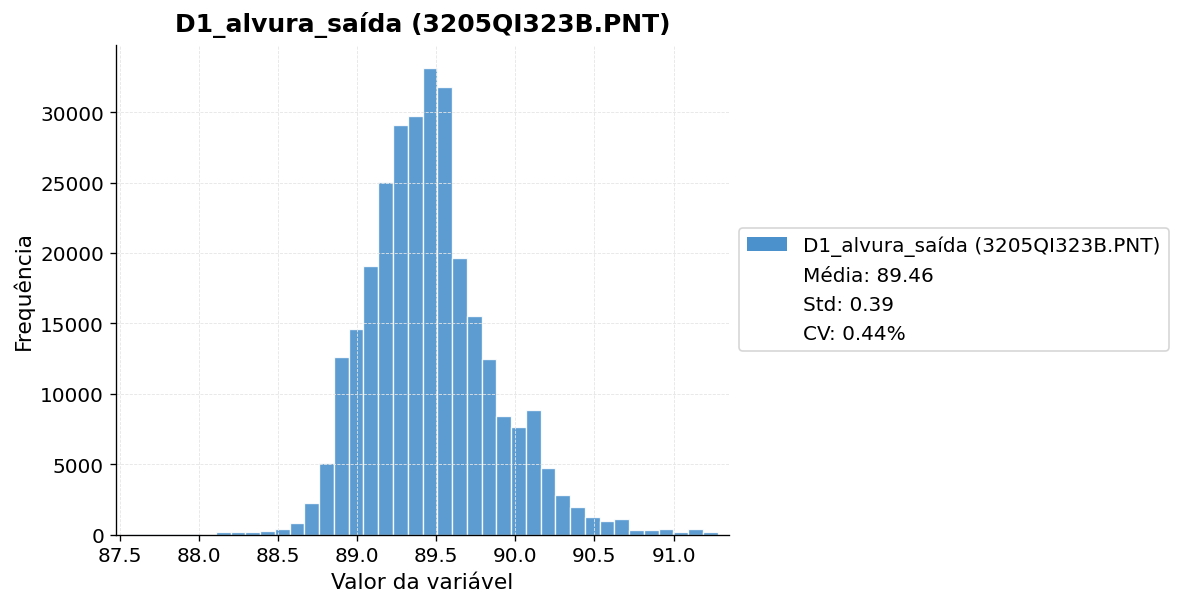

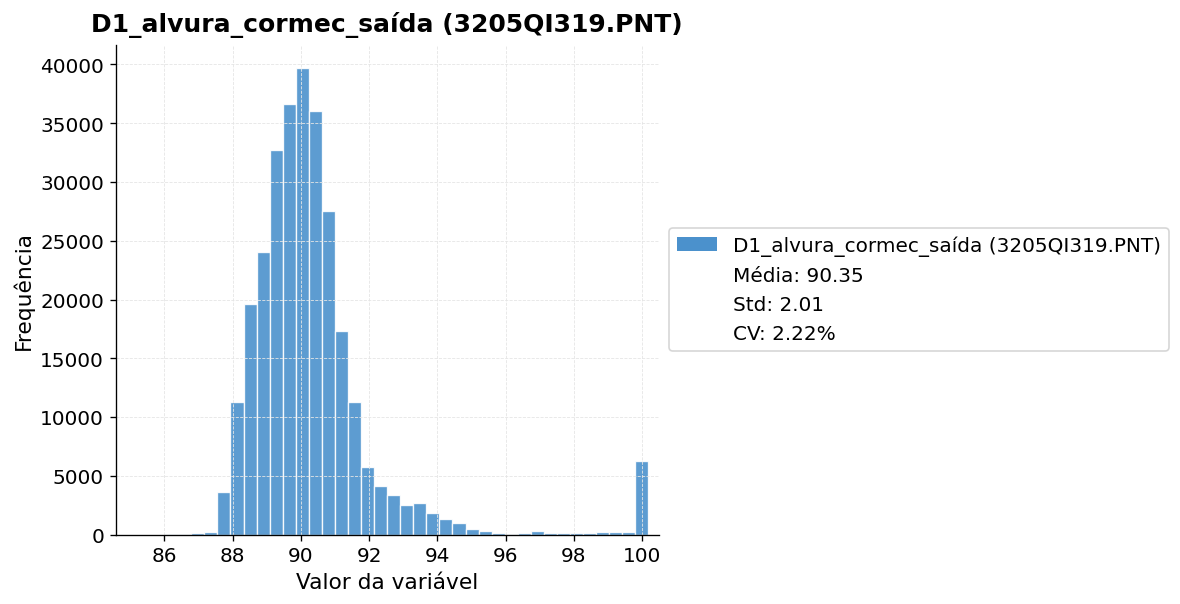

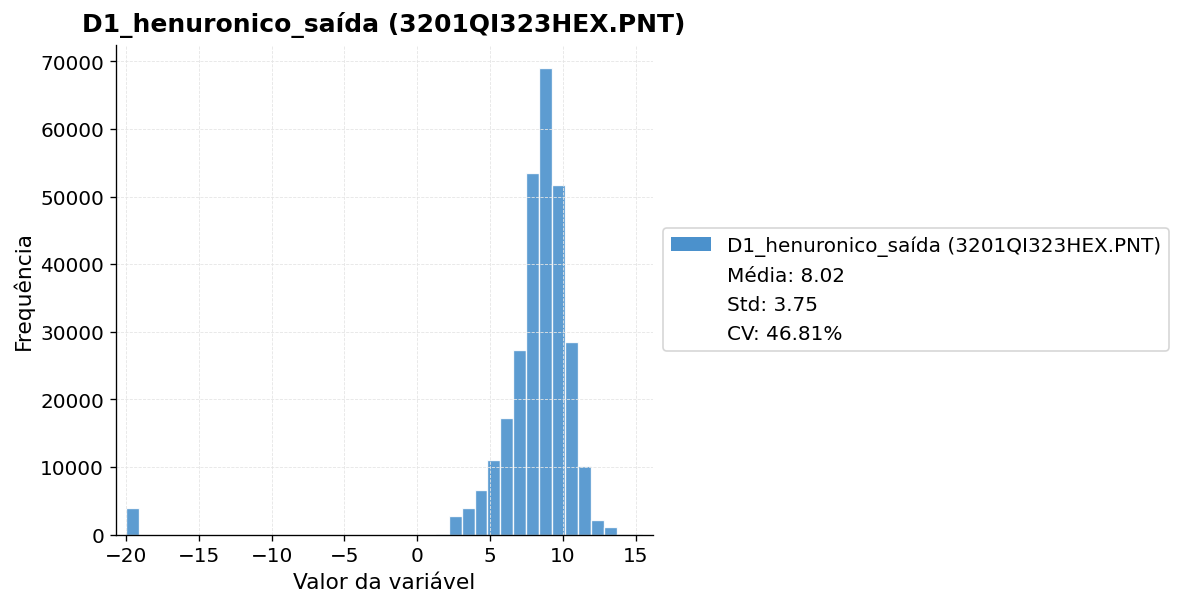

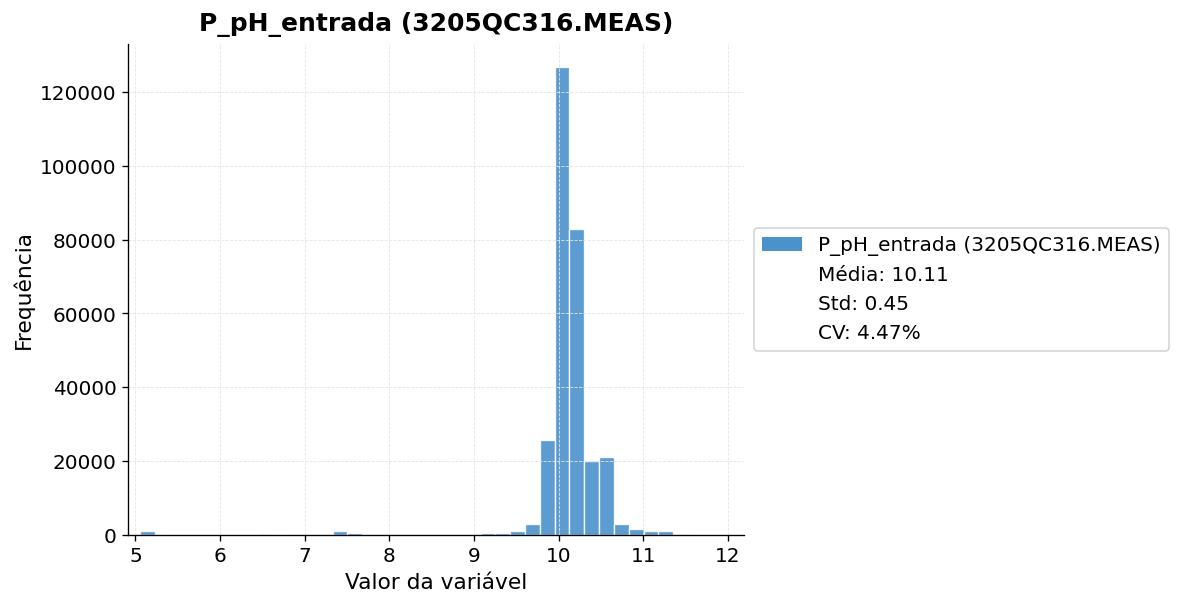

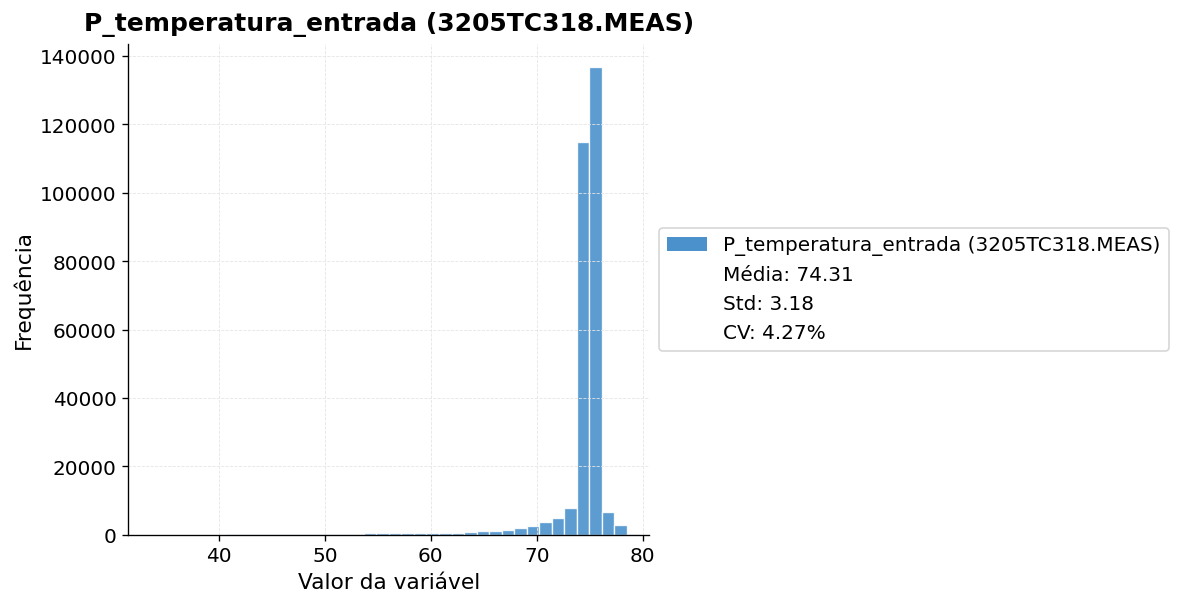

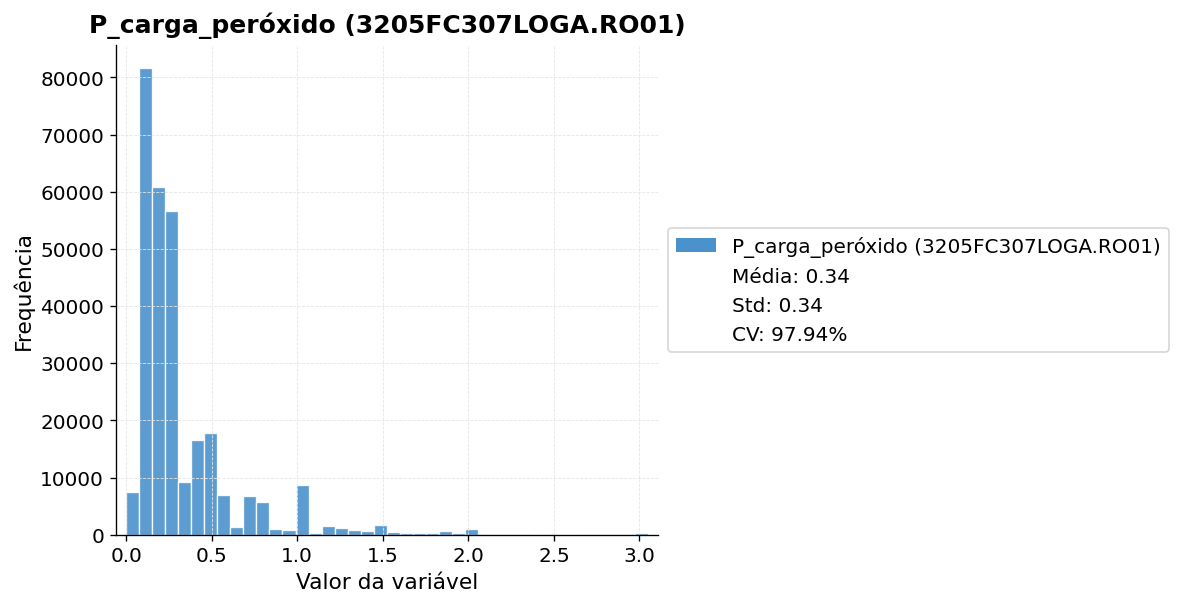

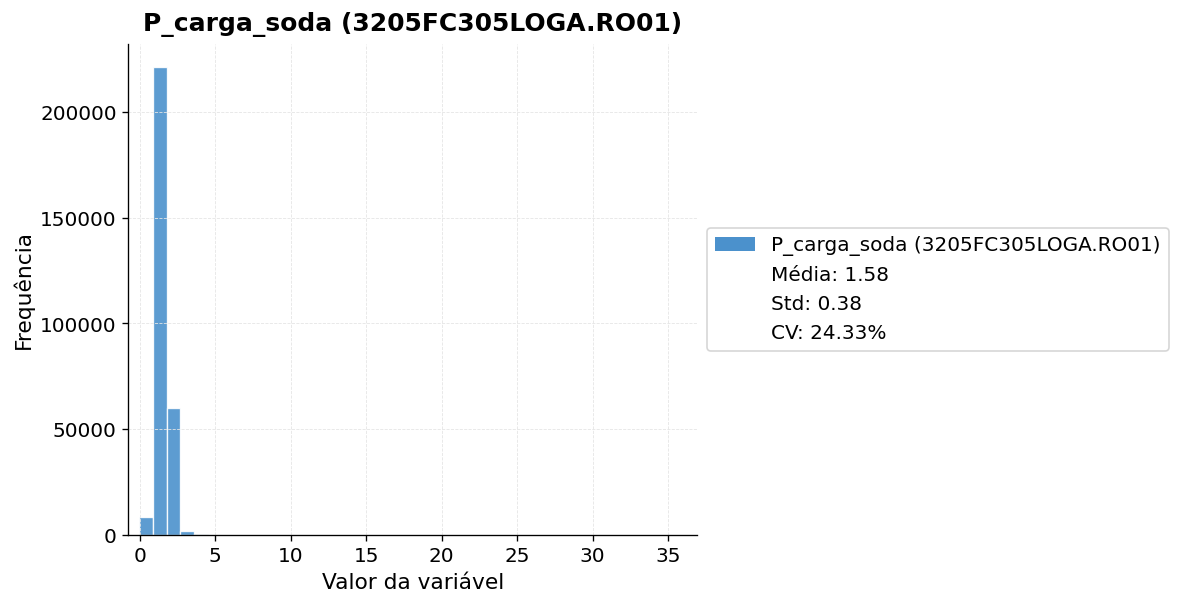

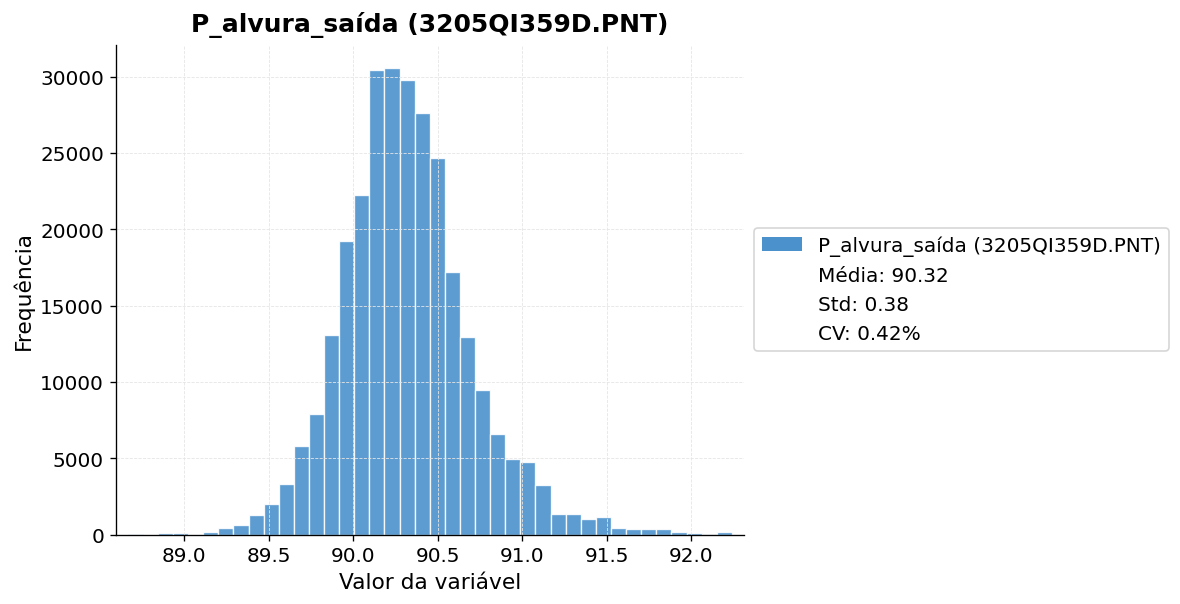

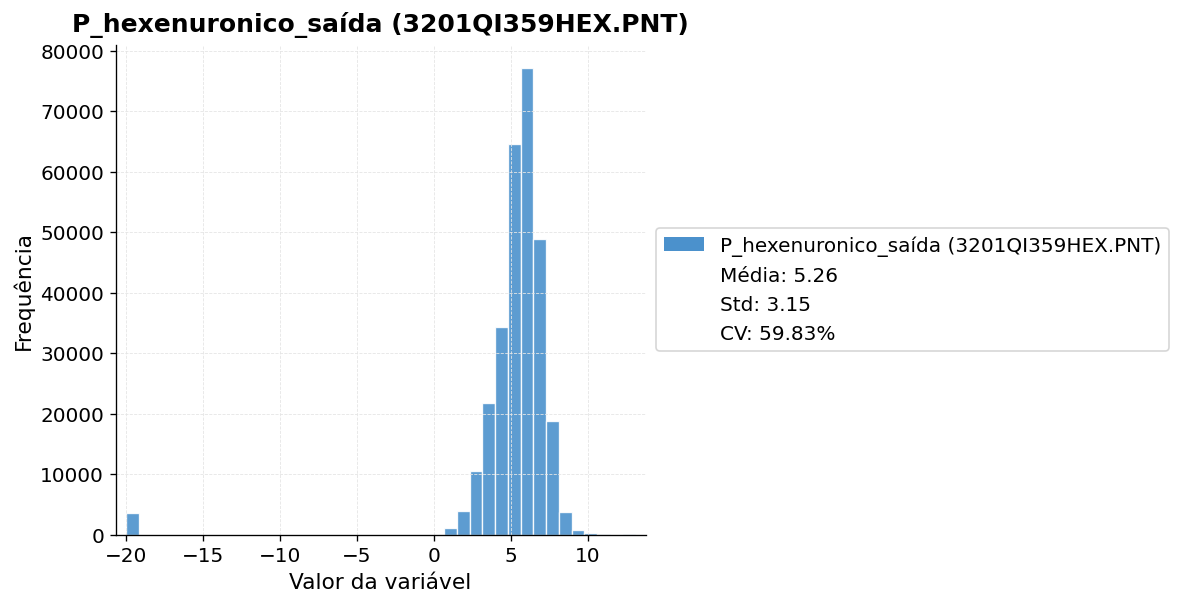

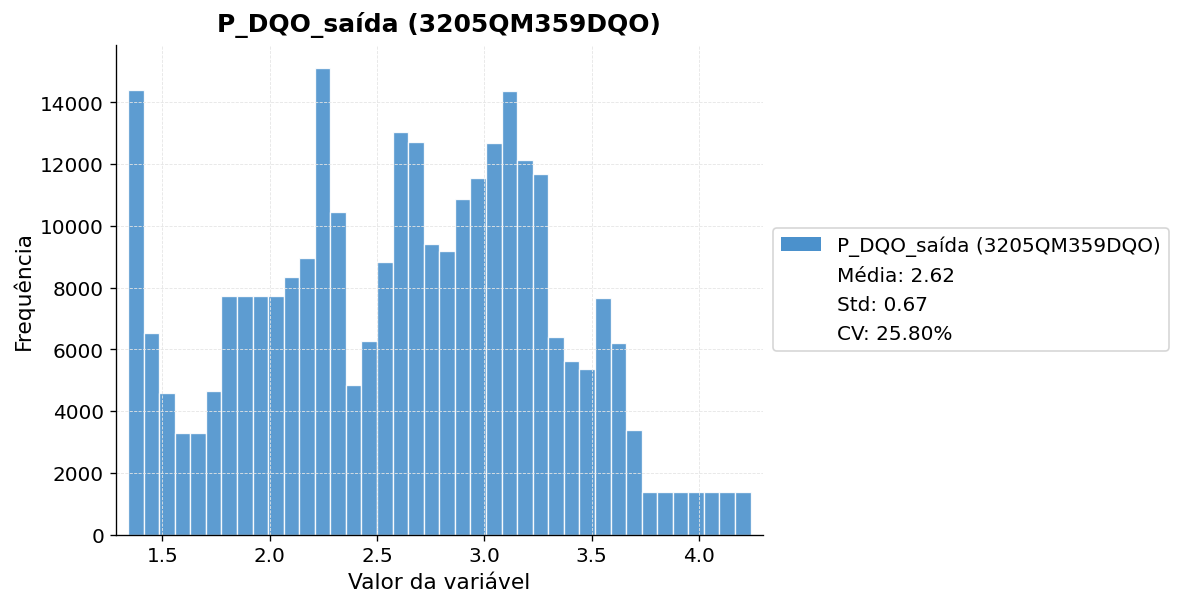

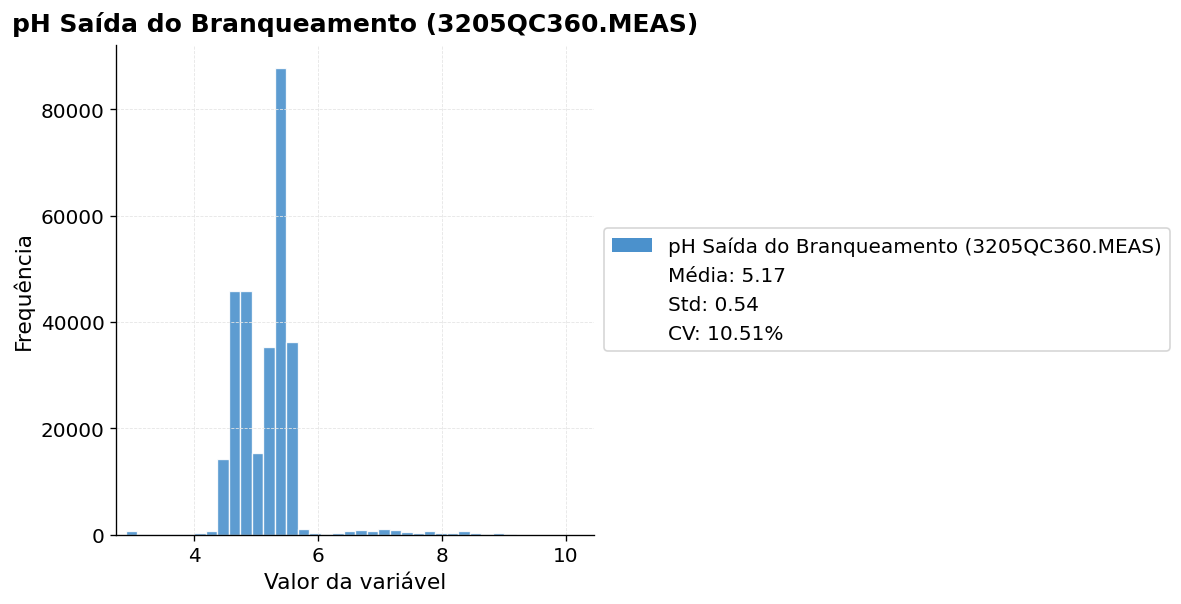

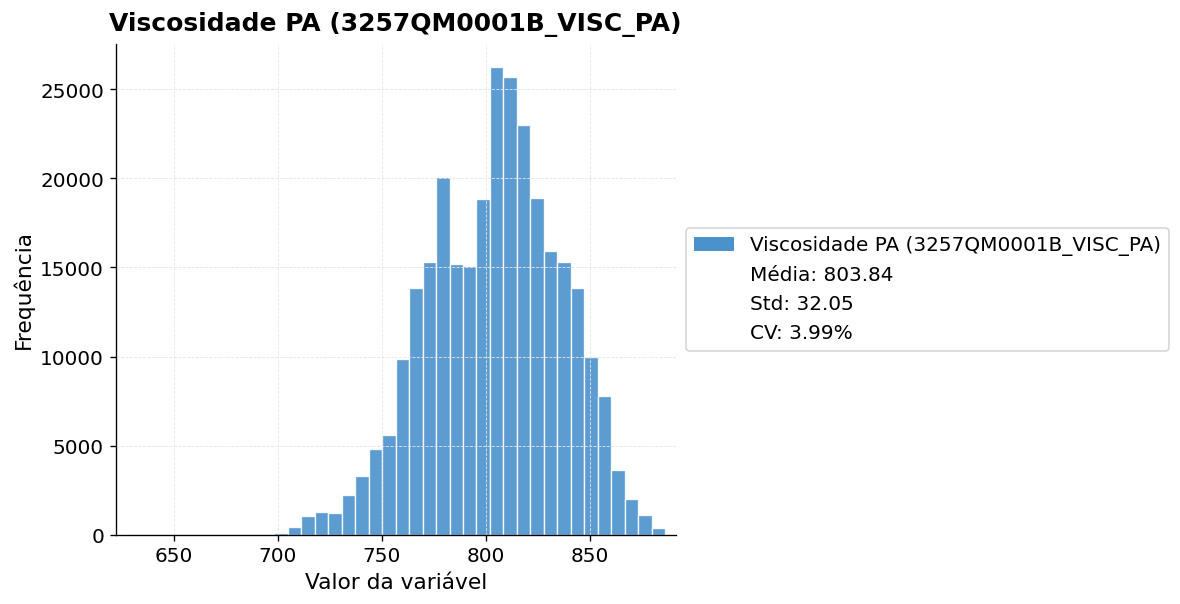

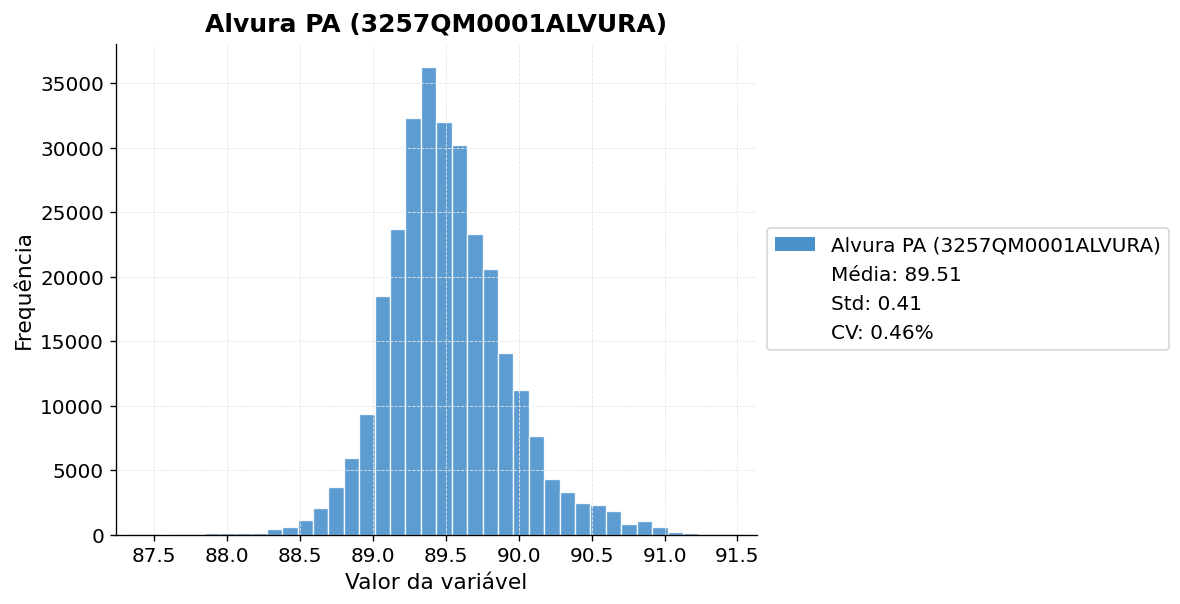

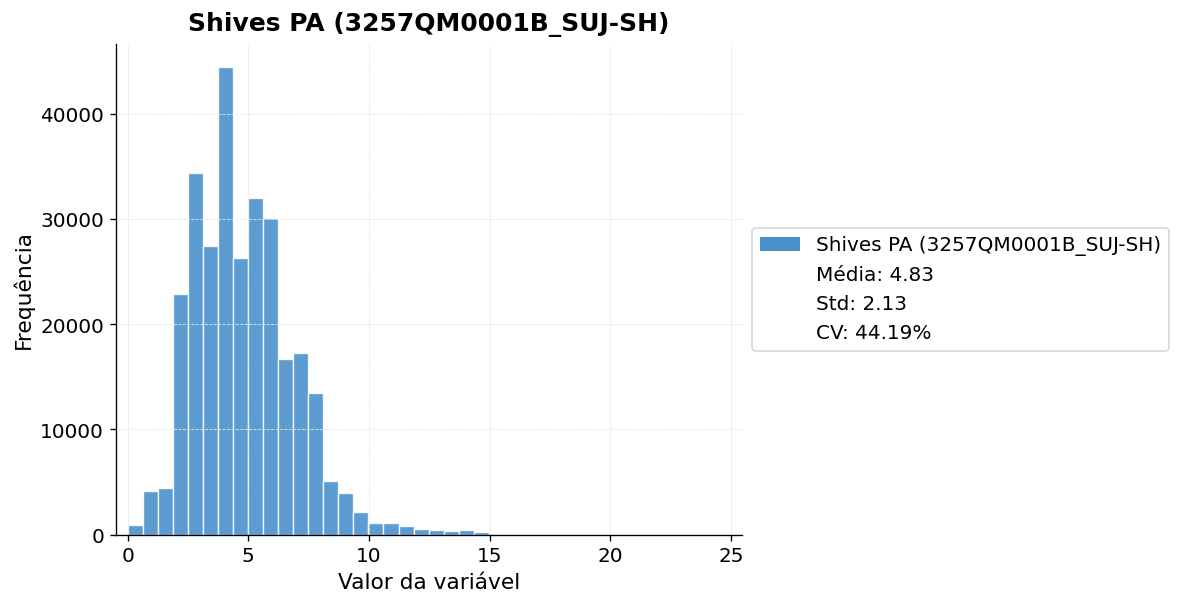

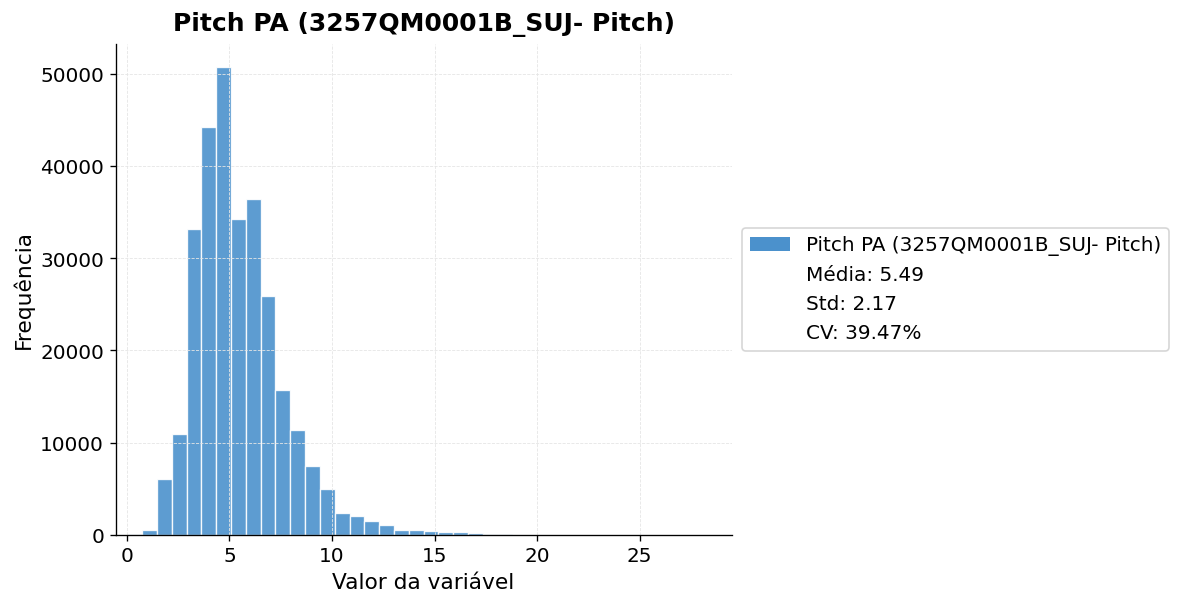

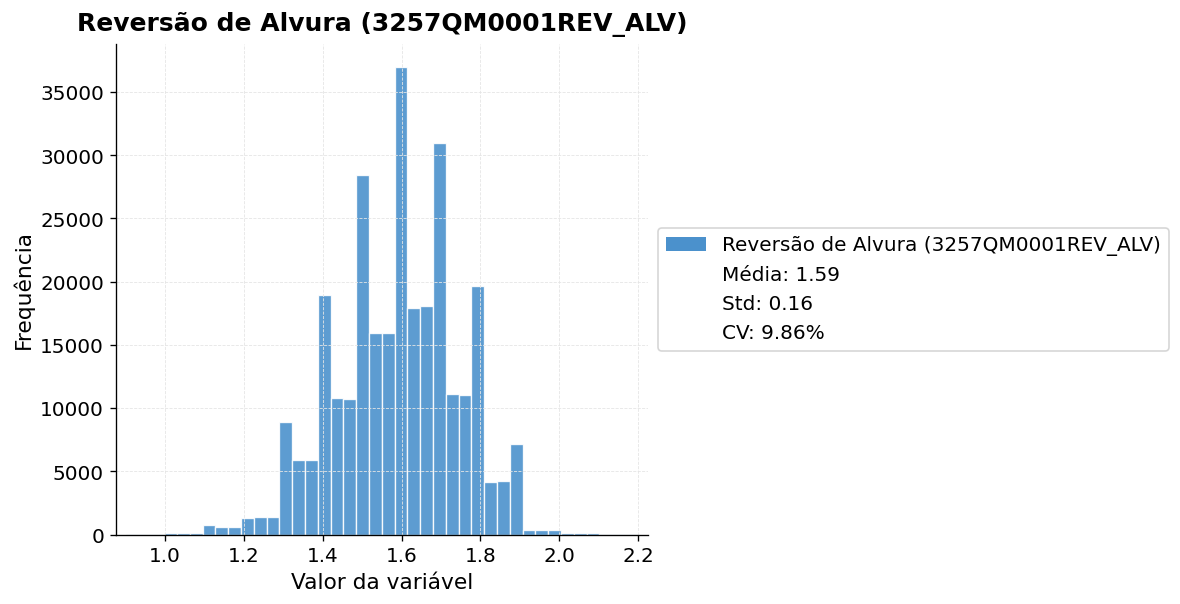

,Título,Média,Std,CV_%,Lo,Hi,%_dentro,%_abaixo,%_acima,N_amostras
0,ritmo_produção (3205FI003.PNT),3070.678777,666.551858,21.706987,2800.0,3500.0,88.548630,11.451370,0.000000,292000
1,Dhot_cs%_alimentação (3205NC008.MEAS),11.250313,1.156485,10.279583,10.0,20.0,96.261036,3.738964,0.000000,292006
2,Dhot_kappa_entrada (3205QI007C.PNT),9.533106,0.661660,6.940659,11.0,14.0,1.598420,98.401580,0.000000,285657
3,Dhot_alvura_entrada (3205QI007D.PNT),61.822275,1.856057,3.002247,60.0,65.0,83.011794,11.734353,5.253853,285657
4,Dhot_dqo_entrada (3205QM007DQO),13.170924,1.905000,14.463681,5.0,9.0,2.097418,0.000000,97.902582,283110


In [33]:
catalog_file = r"..\Banco de dados\limites.csv"
data_file    = r"..\Banco de dados\qualidade.csv"

catalog_df = load_catalog(catalog_file)
data_df    = load_process_data(data_file)

stats_df = plot_from_catalog(catalog_df, data_df, stage=None, save=False)
stats_df.head()

In [38]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from typing import Optional, Dict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [51]:

plt.rcParams.update({"figure.dpi":120, "font.size":11})

# ---------- estatísticas básicas + capacidade ----------
def full_stats(s: pd.Series, lo: Optional[float], hi: Optional[float]) -> Dict[str, float]:
    s = s.dropna()
    mu, sig = s.mean(), s.std(ddof=1)
    p1, p5, p95, p99 = np.percentile(s, [1,5,95,99])
    skew, kurt = s.skew(), s.kurtosis()
    Cp=Cpk=np.nan
    if lo is not None and hi is not None and sig>0:
        Cp  = (hi-lo)/(6*sig)
        Cpk = min(hi-mu, mu-lo)/(3*sig)
    pct_lo = 100*(s<lo).mean() if lo is not None else np.nan
    pct_hi = 100*(s>hi).mean() if hi is not None else np.nan
    return dict(media=mu,std=sig,CV_=100*sig/mu,skew=skew,curt=kurt,
                P1=p1,P5=p5,P95=p95,P99=p99,Cp=Cp,Cpk=Cpk,
                pct_baixo=pct_lo,pct_acima=pct_hi,N=len(s))



In [52]:
def decide_detalhado(row) -> tuple[str, str, str]:
    if row["N"] < 30:
        return ("Dados insuficientes",
                "Baixa",
                "Coletar ≥ 30 amostras antes de avaliar")
    
    if not row["Estável"]:
        return ("Instável",
                "Alta",
                "Investigar causa especial; estabilizar antes de ajuste")
    
    pct_fora = (row["pct_baixo"] or 0) + (row["pct_acima"] or 0)
    
    if row["Cpk"] >= 1.33 and pct_fora <= 0.5:
        return ("OK",
                "Baixa",
                "Manter monitoramento rotineiro")
    
    if 1.00 <= row["Cpk"] < 1.33:
        return ("Marginal",
                "Média",
                "Reduzir variabilidade (σ) ou avaliar apertar limites")
    
    return ("Incapaz",
            "Alta",
            "Rever limites e reduzir variabilidade; possível re-centro")

In [55]:
from typing import Optional, Dict, List

In [57]:
def full_stats(s: pd.Series,
               lo: Optional[float],
               hi: Optional[float]) -> Dict[str, float]:
    s = s.dropna()
    mu, sig = s.mean(), s.std(ddof=1)
    p1, p5, p95, p99 = np.percentile(s, [1, 5, 95, 99])
    skew, kurt = s.skew(), s.kurtosis()
    Cp = Cpk = np.nan
    if lo is not None and hi is not None and sig > 0:
        Cp  = (hi - lo) / (6 * sig)
        Cpk = min(hi - mu, mu - lo) / (3 * sig)
    pct_lo = 100 * (s < lo).mean() if lo is not None else np.nan
    pct_hi = 100 * (s > hi).mean() if hi is not None else np.nan
    return dict(media=mu, std=sig, CV_=100*sig/mu, skew=skew, curt=kurt,
                P1=p1, P5=p5, P95=p95, P99=p99,
                Cp=Cp, Cpk=Cpk, pct_baixo=pct_lo, pct_acima=pct_hi, N=len(s))

# -------------------------------------------------
# 2. Estabilidade (Individuals / MR)
# -------------------------------------------------
def is_stable(series: pd.Series, window:int = 50) -> bool:
    s = series.dropna().tail(window)
    if s.empty: return False
    mu, sig = s.mean(), s.std(ddof=1)
    # ponto fora ±3σ
    if ((s > mu + 3*sig) | (s < mu - 3*sig)).any(): return False
    # 8 pontos do mesmo lado da média
    side = (s > mu).astype(int) - (s < mu).astype(int)
    if (side.rolling(8).sum().abs() == 8).any(): return False
    return True

# -------------------------------------------------
# 3. Decisão detalhada — devolve trio (Status, Prioridade, Ação)
# -------------------------------------------------
def decide_detalhado(row) -> tuple[str, str, str]:
    if row["N"] < 30:
        return ("Dados insuficientes",
                "Baixa",
                "Coletar ≥ 30 amostras antes de avaliar")
    
    if not row["Estável"]:
        return ("Instável",
                "Alta",
                "Investigar causa especial; estabilizar antes de ajuste")
    
    pct_fora = (row["pct_baixo"] or 0) + (row["pct_acima"] or 0)
    
    if row["Cpk"] >= 1.33 and pct_fora <= 0.5:
        return ("OK",
                "Baixa",
                "Manter monitoramento rotineiro")
    
    if 1.00 <= row["Cpk"] < 1.33:
        return ("Marginal",
                "Média",
                "Reduzir variabilidade (σ) ou avaliar apertar limites")
    
    return ("Incapaz",
            "Alta",
            "Rever limites e reduzir variabilidade; possível re-centro")

# -------------------------------------------------
# 4. Loop principal
# -------------------------------------------------
catalog = pd.read_csv(r"..\Banco de dados\limites.csv")
dados   = pd.read_csv(r"..\Banco de dados\qualidade.csv")

records: List[Dict] = []
for _, r in catalog.iterrows():
    tag = str(r["Tag"])
    lo, hi = r.get("LO"), r.get("HI")
    if tag not in dados.columns:
        print("Tag ausente:", tag)
        continue
    
    serie = dados[tag]
    met   = full_stats(serie, lo, hi)
    met.update({
        "Tag": tag,
        "Nome KPI": r["Nome"],
        "Tipo": r.get("Tipo", np.nan),
        "LO": lo,
        "HI": hi,
        "Estável": is_stable(serie)
    })
    records.append(met)

stats_df = pd.DataFrame(records)

# ---- aplicar decisão detalhada (3 colunas) ----
stats_df[["Status", "Prioridade", "Ação"]] = (
    stats_df.apply(decide_detalhado, axis=1, result_type="expand")
)

display(stats_df.head())

,media,std,CV_,skew,curt,P1,P5,P95,P99,Cp,...,N,Tag,Nome KPI,Tipo,LO,HI,Estável,Status,Prioridade,Ação
0,3070.678777,666.551858,21.706987,-3.478591,11.924114,0.000187,1499.789641,3374.697507,3399.453116,0.175030,...,292000,3205FI003.PNT,ritmo_produção,NaN,2800.0,3500.0,False,Instável,Alta,Investigar causa especial; estabilizar antes d...
1,11.250313,1.156485,10.279583,-4.885783,23.278127,5.000797,10.823703,11.763242,11.845449,1.441148,...,292006,3205NC008.MEAS,Dhot_cs%_alimentação,NaN,10.0,20.0,False,Instável,Alta,Investigar causa especial; estabilizar antes d...
2,9.533106,0.661660,6.940659,-0.618947,3.806552,7.386700,8.554949,10.508743,11.321146,0.755675,...,285657,3205QI007C.PNT,Dhot_kappa_entrada,NaN,11.0,14.0,False,Instável,Alta,Investigar causa especial; estabilizar antes d...
3,61.822275,1.856057,3.002247,-0.179463,1.872021,57.325970,58.581501,65.087433,66.552844,0.448980,...,285657,3205QI007D.PNT,Dhot_alvura_entrada,NaN,60.0,65.0,False,Instável,Alta,Investigar causa especial; estabilizar antes d...
4,13.170924,1.905000,14.463681,-0.463960,-0.203258,8.058272,9.906387,15.762940,16.788675,0.349956,...,283110,3205QM007DQO,Dhot_dqo_entrada,NaN,5.0,9.0,False,Instável,Alta,Investigar causa especial; estabilizar antes d...


In [59]:
stats_df.to_excel("output.xlsx", index=False)

In [4]:
# 2. Importando a biblioteca
import numpy as np
import manufacturing

# 3. Gerando dados de exemplo (normalmente, você usaria seus dados reais)
data = np.random.normal(loc=10.0, scale=0.2, size=100)

# 4. Definindo os limites de especificação
LSL = 9.5  # Limite inferior
USL = 10.5  # Limite superior

# 5. Plotando o gráfico de Cpk (e visualizando Cp/Ppk etc.)
manufacturing.ppk_plot(data, lower_specification_limit=LSL, upper_specification_limit=USL)

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.